In [21]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [22]:
temp_data = torchvision.datasets.MNIST(root='./files', train=True, transform=torchvision.transforms.ToTensor(), download=True)


mean, std= temp_data.data.mean(dtype=torch.float32)/255., temp_data.data.to(torch.float32).std()/255.
mean, std

(tensor(0.1307), tensor(0.3081))

In [23]:
data_transformation = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean, std),
    ]
)

train_data = torchvision.datasets.MNIST(root='./files', train=True, transform=data_transformation, download=True)
validation_data = torchvision.datasets.MNIST(root='./files', train=False, transform=data_transformation, download=True)

"""
train_data = torchvision.datasets.FashionMNIST(root='./files', train=True, transform=data_transformation, download=True)
validation_data = torchvision.datasets.FashionMNIST(root='./files', train=False, transform=data_transformation, download=True)
"""

train_dataloader=torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=0)
validation_dataloader=torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=0)

In [24]:
#latent_dimension = 64
latent_dimension = 128
output_dim = 10

In [25]:
class MyDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, padding=2) 
        
        self.lin1 = nn.Linear(3*3*32 + output_dim, 256)
        self.lin2 = nn.Linear(256, 1)

    def forward(self, x):
        digit = x[1]
        x=x[0]
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size = 2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size = 2))
        x = F.relu(F.max_pool2d(self.conv3(x), kernel_size = 2))
        x = F.relu(self.lin1(torch.cat((torch.flatten(x, 1), digit), dim=1)))
        x = F.sigmoid(self.lin2(x))
        return x

In [26]:
class MyGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(latent_dimension + output_dim,  16*28*28)
        self.convt1 = nn.ConvTranspose2d(16, 8, kernel_size=5, padding=2)
        self.convt2 = nn.ConvTranspose2d(8, 4, kernel_size=5, padding=2)
        self.conv = nn.Conv2d(4, 1, kernel_size=5, padding=2)
        self.shortcut_conv = nn.Conv2d(4, 1, kernel_size=1)
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = x.reshape(x.size(0), 16, 28, 28)
        x = F.relu(self.convt1(x))
        x = F.relu(self.convt2(x))
        x = F.sigmoid(self.shortcut_conv(x)+self.conv(x))
        return x

In [27]:
discriminator = MyDiscriminator().to(device)
generator = MyGenerator().to(device)
print(f"Discriminator Model structure: {discriminator}\n")
print(f"Generator Model structure: {generator}\n")

Discriminator Model structure: MyDiscriminator(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lin1): Linear(in_features=298, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=1, bias=True)
)

Generator Model structure: MyGenerator(
  (lin1): Linear(in_features=138, out_features=12544, bias=True)
  (convt1): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (convt2): ConvTranspose2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (shortcut_conv): Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))
)



In [28]:
learning_rate=0.0002
batch_size=64
epochs=200
noise_0 = 0.5
noise_decay = 0.9
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)

Epoch 0, Noise 0.5:


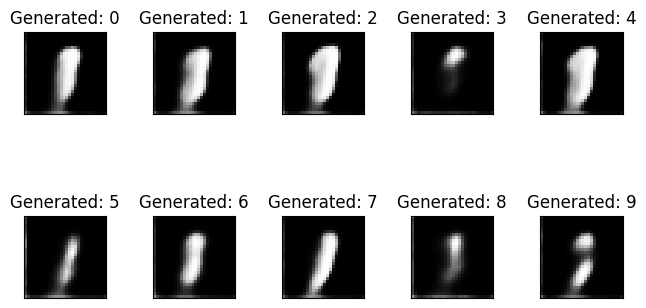

Real Discriminator Accuracy: 0.9337
Fake Discriminator Accuracy: 0.8433
Epoch 1, Noise 0.45:


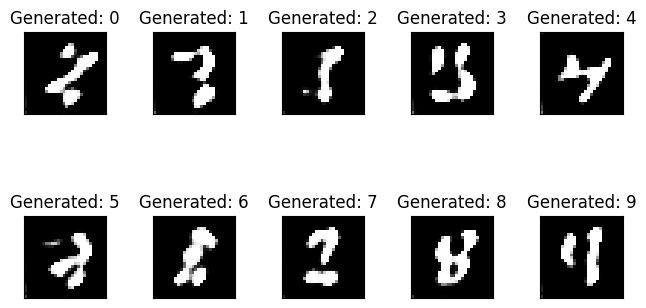

Real Discriminator Accuracy: 0.7437
Fake Discriminator Accuracy: 0.6804
Epoch 2, Noise 0.405:


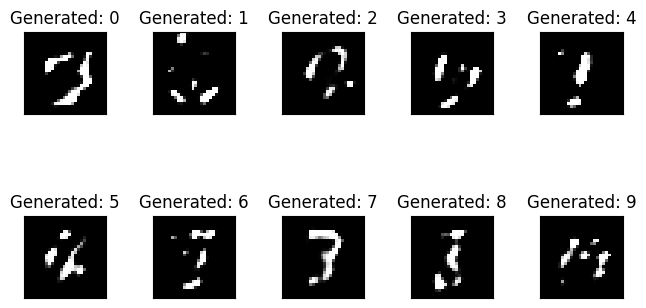

Real Discriminator Accuracy: 0.7314
Fake Discriminator Accuracy: 0.7903
Epoch 3, Noise 0.36450000000000005:


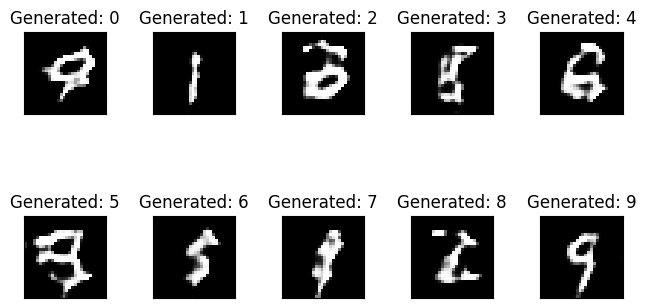

Real Discriminator Accuracy: 0.7527
Fake Discriminator Accuracy: 0.7535
Epoch 4, Noise 0.32805:


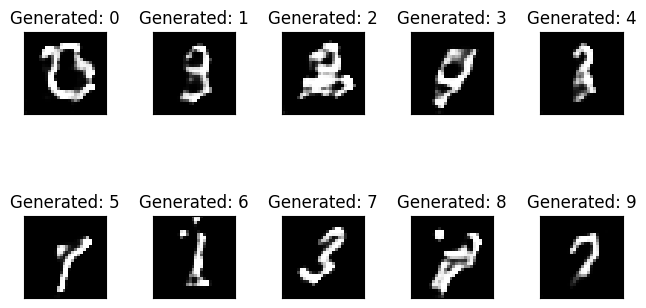

Real Discriminator Accuracy: 0.809
Fake Discriminator Accuracy: 0.8063
Epoch 5, Noise 0.29524500000000004:


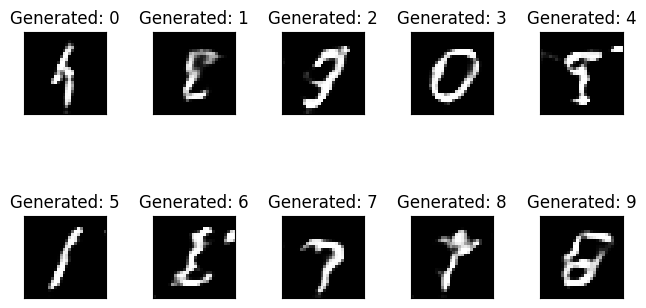

Real Discriminator Accuracy: 0.8454
Fake Discriminator Accuracy: 0.7893
Epoch 6, Noise 0.2657205:


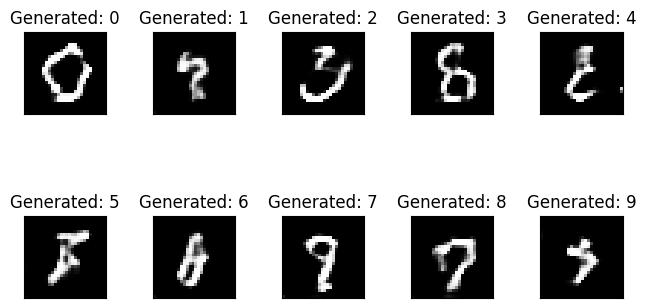

Real Discriminator Accuracy: 0.9218
Fake Discriminator Accuracy: 0.7693
Epoch 7, Noise 0.23914845000000004:


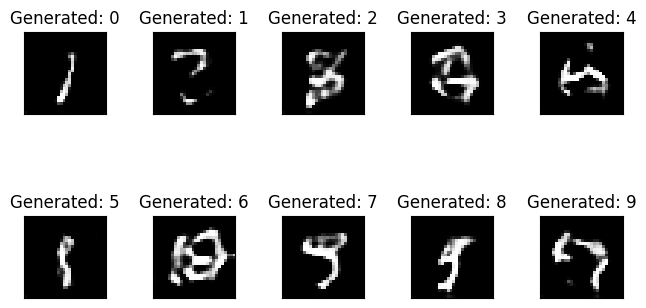

Real Discriminator Accuracy: 0.803
Fake Discriminator Accuracy: 0.9177
Epoch 8, Noise 0.21523360500000005:


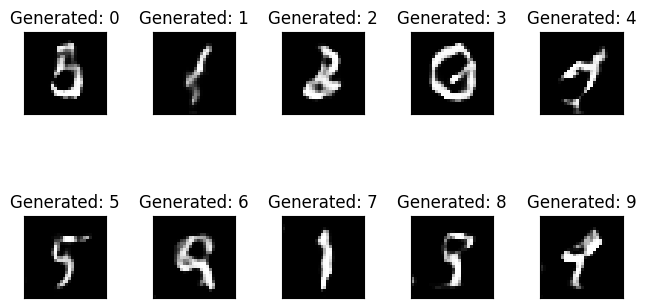

Real Discriminator Accuracy: 0.8916
Fake Discriminator Accuracy: 0.8782
Epoch 9, Noise 0.19371024450000005:


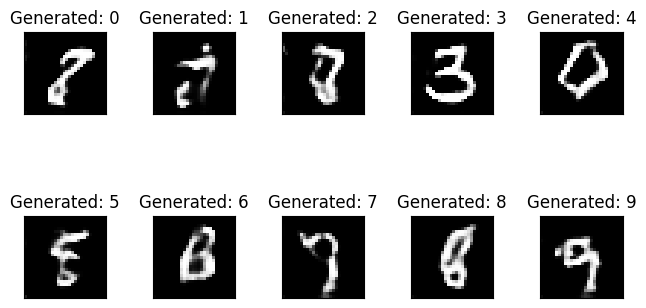

Real Discriminator Accuracy: 0.7321
Fake Discriminator Accuracy: 0.8612
Epoch 10, Noise 0.17433922005000005:


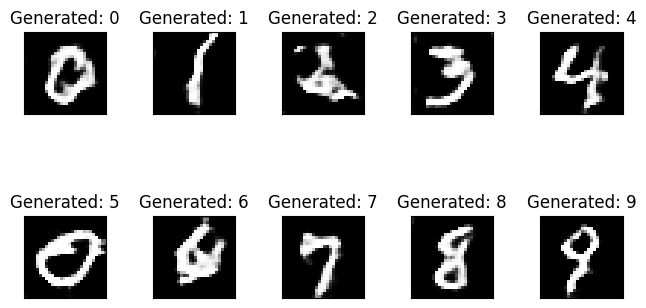

Real Discriminator Accuracy: 0.6848
Fake Discriminator Accuracy: 0.9143
Epoch 11, Noise 0.15690529804500003:


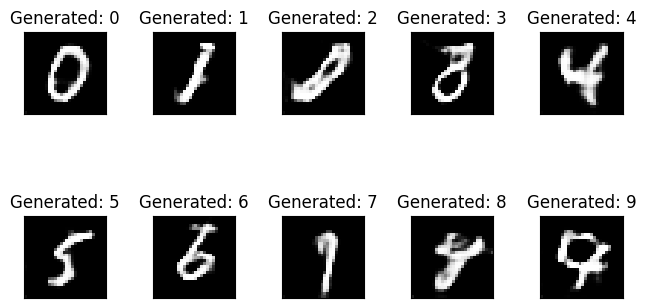

Real Discriminator Accuracy: 0.7233
Fake Discriminator Accuracy: 0.8183
Epoch 12, Noise 0.14121476824050005:


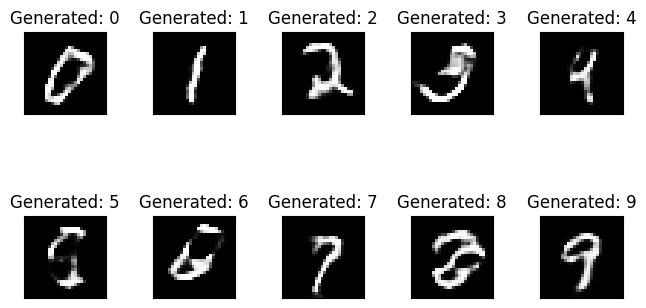

Real Discriminator Accuracy: 0.6558
Fake Discriminator Accuracy: 0.835
Epoch 13, Noise 0.12709329141645004:


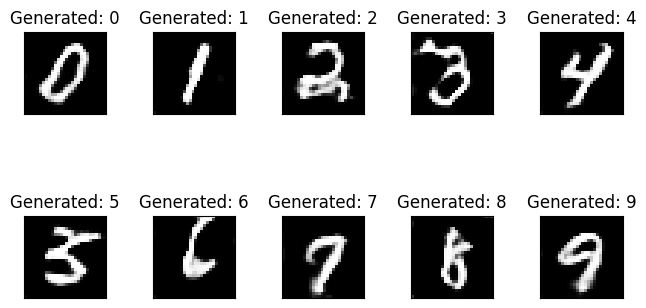

Real Discriminator Accuracy: 0.5306
Fake Discriminator Accuracy: 0.913
Epoch 14, Noise 0.11438396227480505:


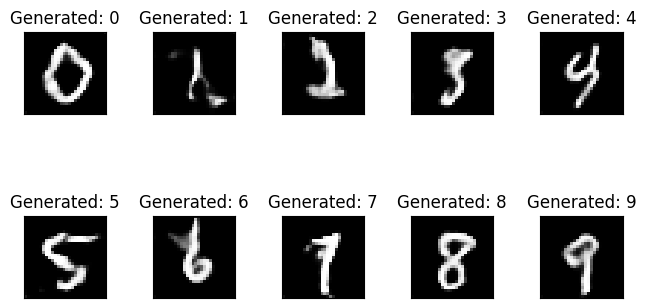

Real Discriminator Accuracy: 0.7359
Fake Discriminator Accuracy: 0.7258
Epoch 15, Noise 0.10294556604732454:


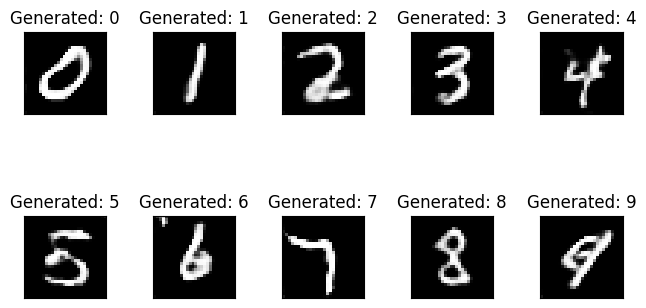

Real Discriminator Accuracy: 0.7405
Fake Discriminator Accuracy: 0.6297
Epoch 16, Noise 0.09265100944259208:


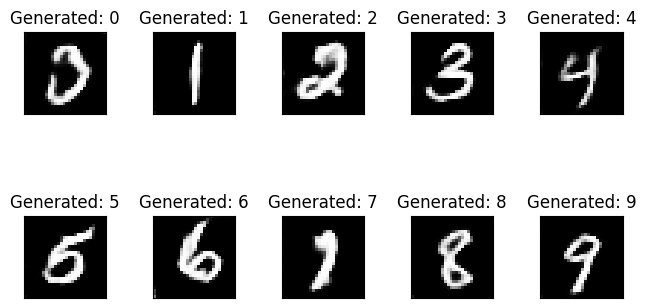

Real Discriminator Accuracy: 0.7034
Fake Discriminator Accuracy: 0.734
Epoch 17, Noise 0.08338590849833288:


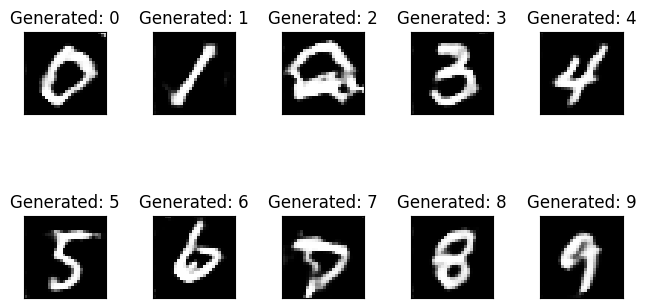

Real Discriminator Accuracy: 0.6187
Fake Discriminator Accuracy: 0.7963
Epoch 18, Noise 0.07504731764849959:


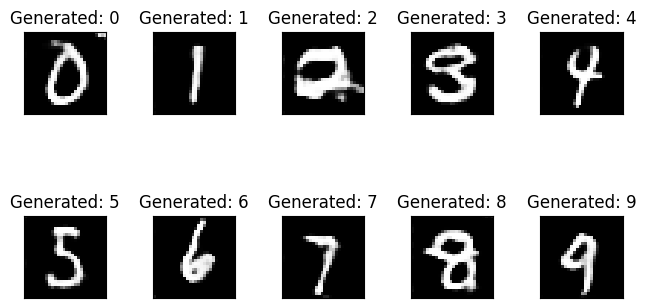

Real Discriminator Accuracy: 0.7082
Fake Discriminator Accuracy: 0.6455
Epoch 19, Noise 0.06754258588364964:


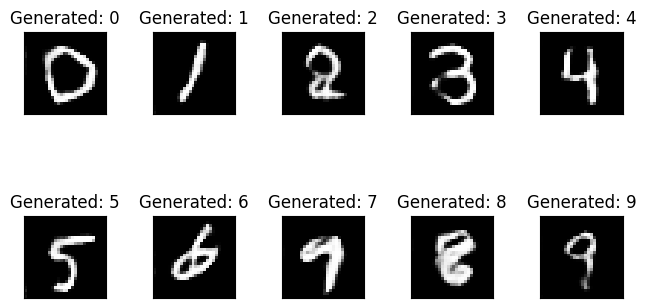

Real Discriminator Accuracy: 0.6854
Fake Discriminator Accuracy: 0.7689
Epoch 20, Noise 0.060788327295284675:


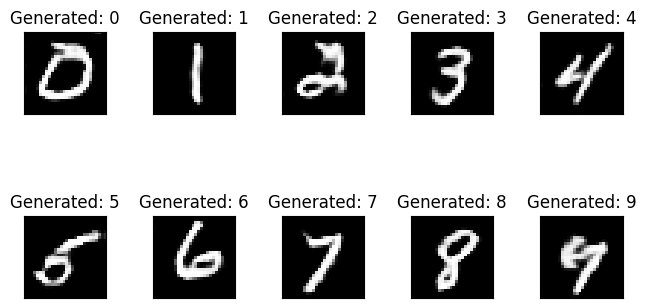

Real Discriminator Accuracy: 0.6799
Fake Discriminator Accuracy: 0.6988
Epoch 21, Noise 0.05470949456575621:


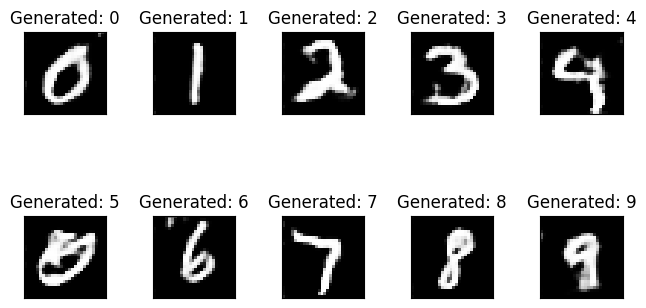

Real Discriminator Accuracy: 0.5693
Fake Discriminator Accuracy: 0.7853
Epoch 22, Noise 0.04923854510918059:


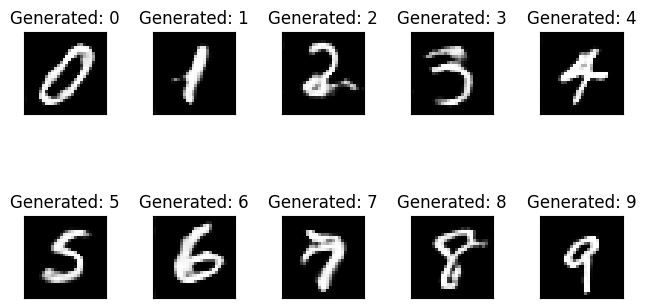

Real Discriminator Accuracy: 0.5432
Fake Discriminator Accuracy: 0.8205
Epoch 23, Noise 0.044314690598262534:


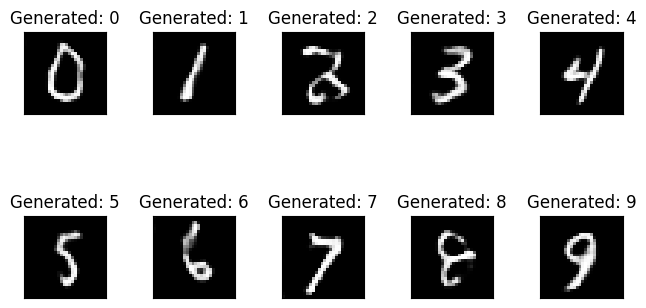

Real Discriminator Accuracy: 0.8603
Fake Discriminator Accuracy: 0.6688
Epoch 24, Noise 0.03988322153843628:


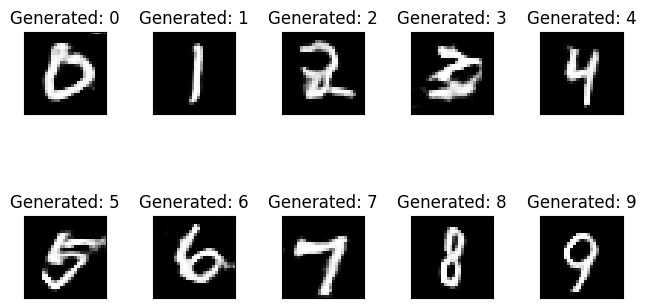

Real Discriminator Accuracy: 0.558
Fake Discriminator Accuracy: 0.8406
Epoch 25, Noise 0.03589489938459265:


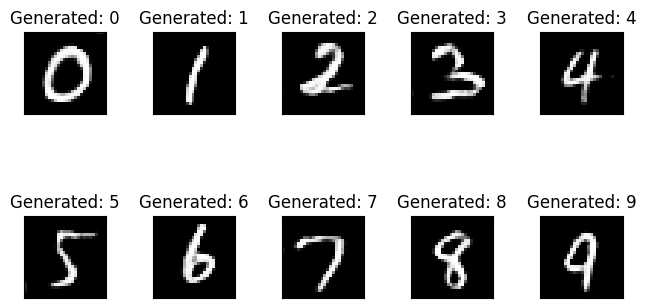

Real Discriminator Accuracy: 0.6287
Fake Discriminator Accuracy: 0.7314
Epoch 26, Noise 0.03230540944613339:


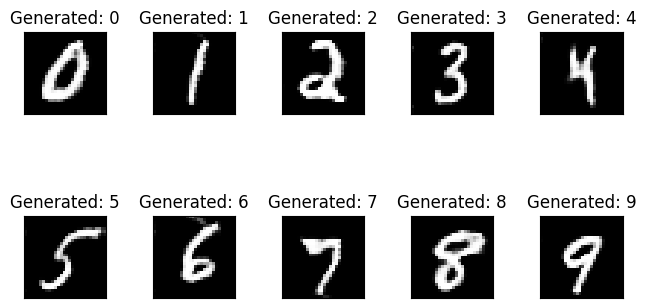

Real Discriminator Accuracy: 0.6833
Fake Discriminator Accuracy: 0.7528
Epoch 27, Noise 0.029074868501520048:


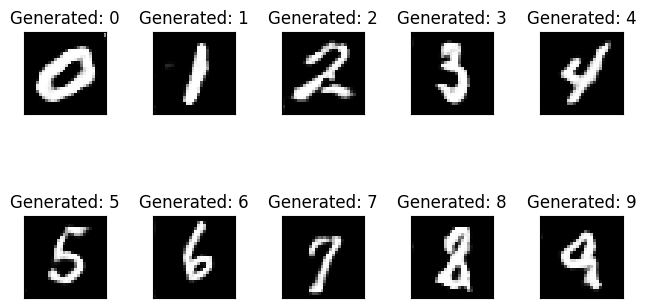

Real Discriminator Accuracy: 0.6613
Fake Discriminator Accuracy: 0.7979
Epoch 28, Noise 0.026167381651368046:


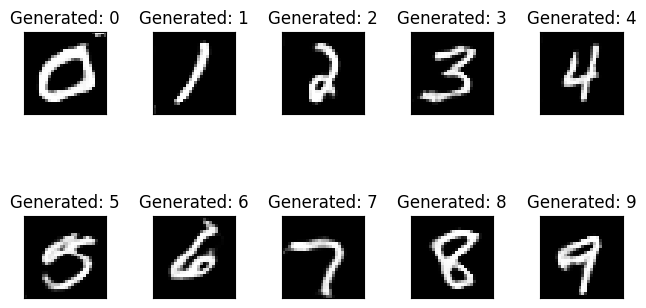

Real Discriminator Accuracy: 0.6921
Fake Discriminator Accuracy: 0.6584
Epoch 29, Noise 0.023550643486231242:


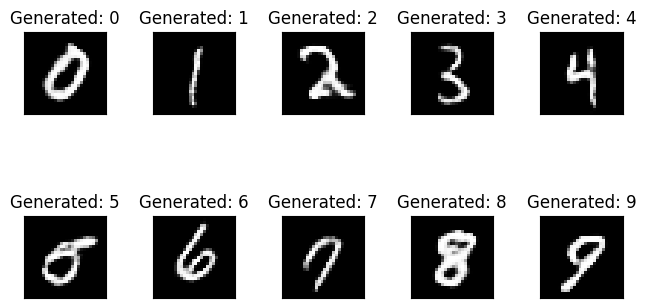

Real Discriminator Accuracy: 0.7247
Fake Discriminator Accuracy: 0.7697
Epoch 30, Noise 0.02119557913760812:


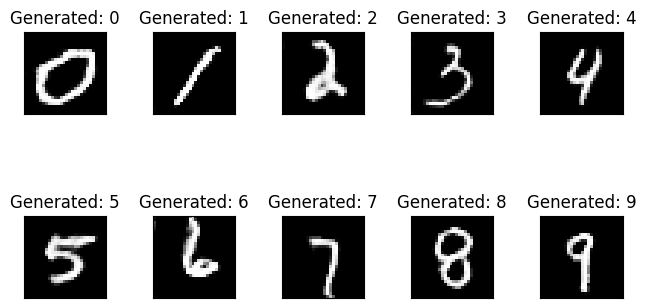

Real Discriminator Accuracy: 0.6521
Fake Discriminator Accuracy: 0.6616
Epoch 31, Noise 0.019076021223847307:


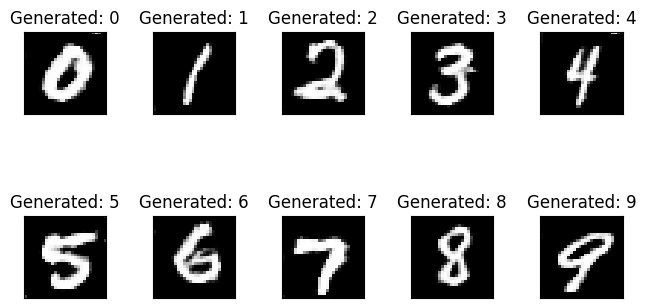

Real Discriminator Accuracy: 0.5623
Fake Discriminator Accuracy: 0.754
Epoch 32, Noise 0.017168419101462575:


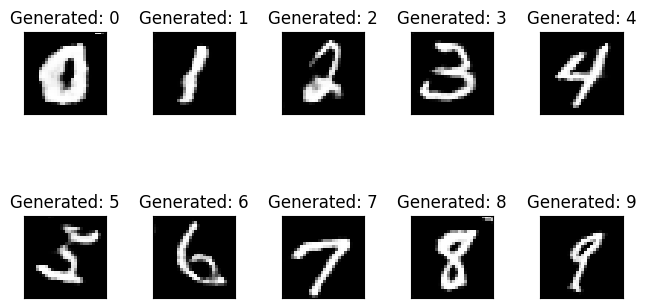

Real Discriminator Accuracy: 0.641
Fake Discriminator Accuracy: 0.7678
Epoch 33, Noise 0.015451577191316318:


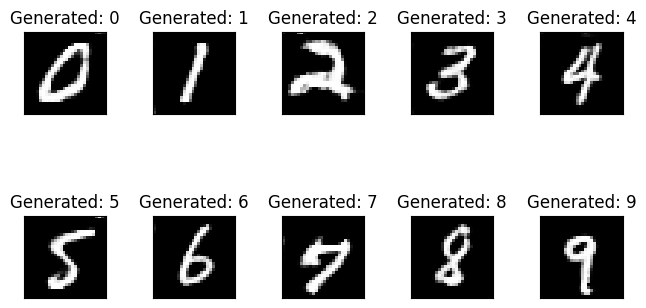

Real Discriminator Accuracy: 0.5481
Fake Discriminator Accuracy: 0.7228
Epoch 34, Noise 0.013906419472184687:


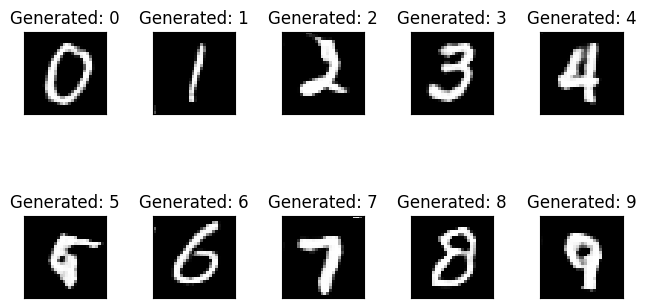

Real Discriminator Accuracy: 0.6249
Fake Discriminator Accuracy: 0.7234
Epoch 35, Noise 0.012515777524966219:


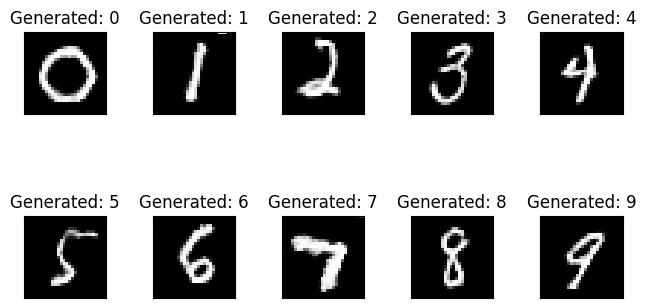

Real Discriminator Accuracy: 0.728
Fake Discriminator Accuracy: 0.7019
Epoch 36, Noise 0.011264199772469598:


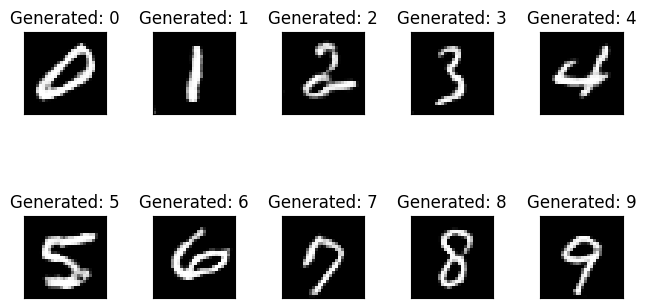

Real Discriminator Accuracy: 0.5561
Fake Discriminator Accuracy: 0.7693
Epoch 37, Noise 0.010137779795222637:


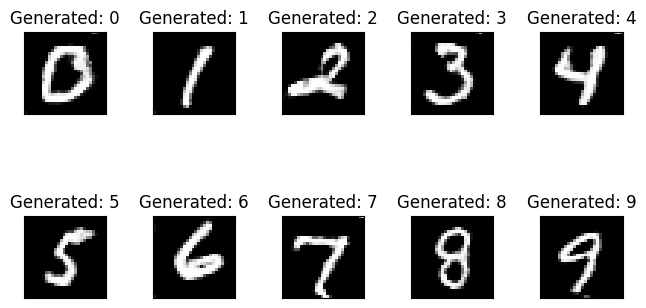

Real Discriminator Accuracy: 0.6639
Fake Discriminator Accuracy: 0.6396
Epoch 38, Noise 0.009124001815700375:


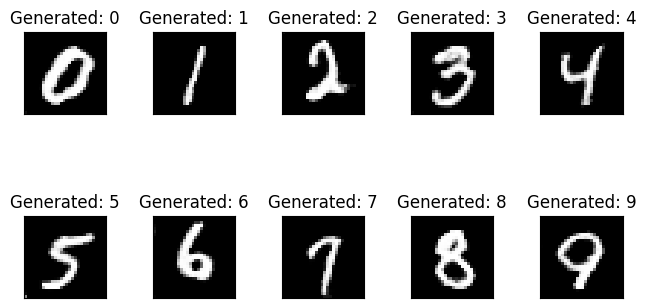

Real Discriminator Accuracy: 0.4948
Fake Discriminator Accuracy: 0.8464
Epoch 39, Noise 0.008211601634130337:


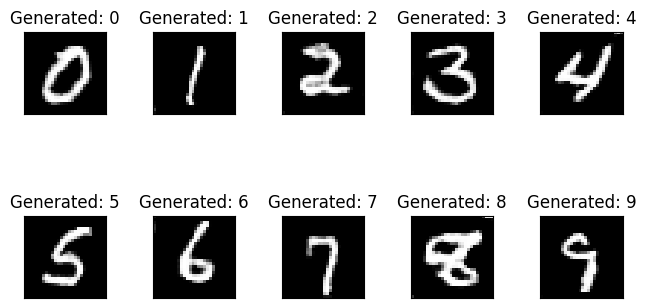

Real Discriminator Accuracy: 0.7465
Fake Discriminator Accuracy: 0.6321
Epoch 40, Noise 0.007390441470717304:


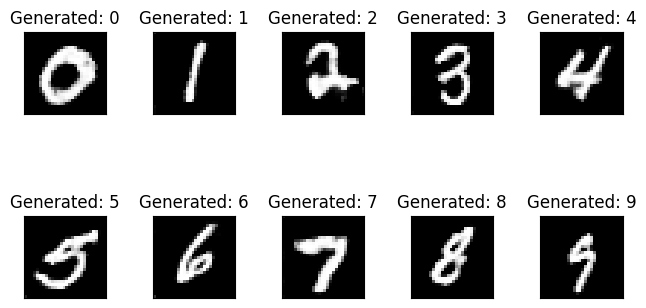

Real Discriminator Accuracy: 0.4503
Fake Discriminator Accuracy: 0.8059
Epoch 41, Noise 0.006651397323645573:


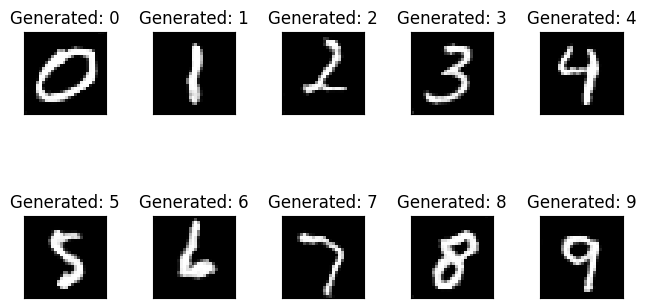

Real Discriminator Accuracy: 0.7008
Fake Discriminator Accuracy: 0.7307
Epoch 42, Noise 0.005986257591281016:


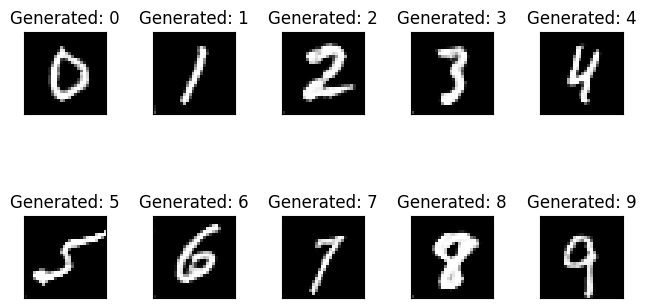

Real Discriminator Accuracy: 0.5763
Fake Discriminator Accuracy: 0.7022
Epoch 43, Noise 0.005387631832152915:


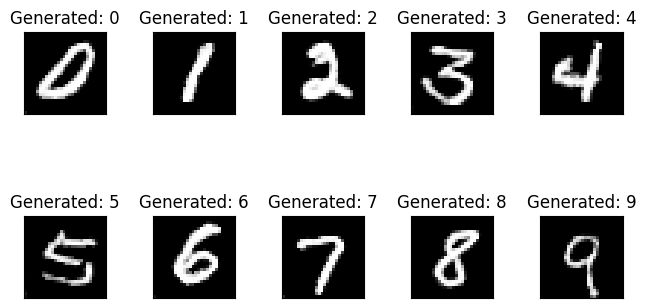

Real Discriminator Accuracy: 0.6075
Fake Discriminator Accuracy: 0.7802
Epoch 44, Noise 0.004848868648937623:


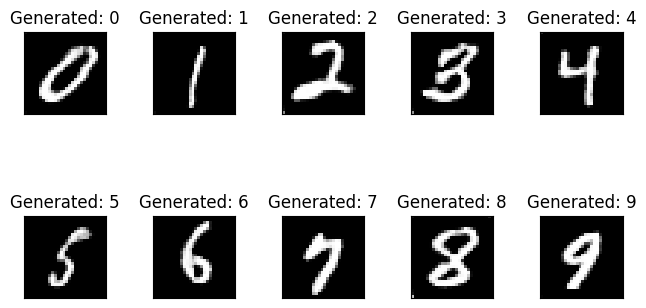

Real Discriminator Accuracy: 0.588
Fake Discriminator Accuracy: 0.8143
Epoch 45, Noise 0.004363981784043861:


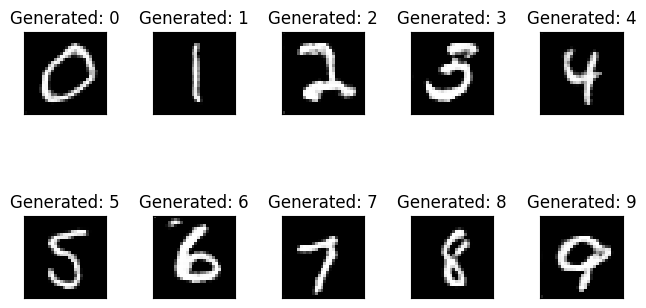

Real Discriminator Accuracy: 0.5881
Fake Discriminator Accuracy: 0.7089
Epoch 46, Noise 0.003927583605639475:


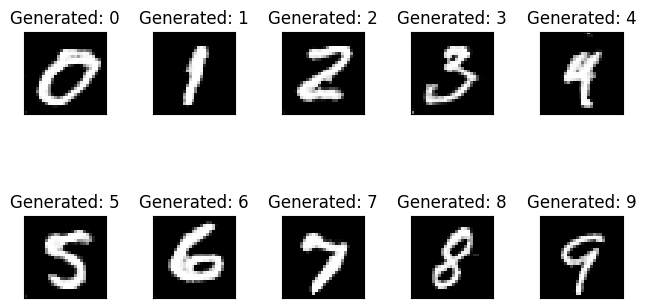

Real Discriminator Accuracy: 0.5236
Fake Discriminator Accuracy: 0.8454
Epoch 47, Noise 0.0035348252450755277:


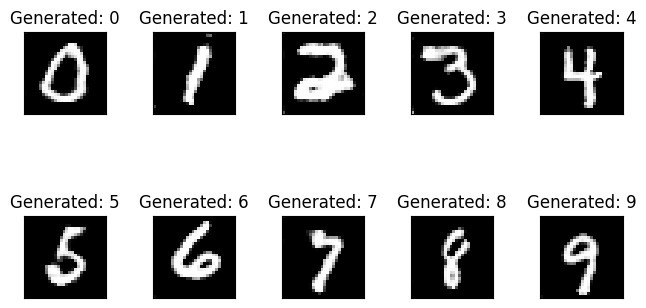

Real Discriminator Accuracy: 0.618
Fake Discriminator Accuracy: 0.7556
Epoch 48, Noise 0.003181342720567975:


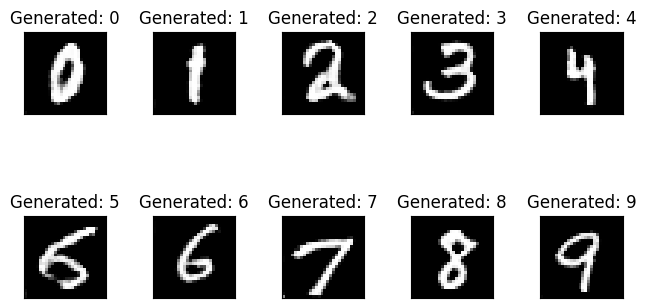

Real Discriminator Accuracy: 0.5768
Fake Discriminator Accuracy: 0.804
Epoch 49, Noise 0.0028632084485111773:


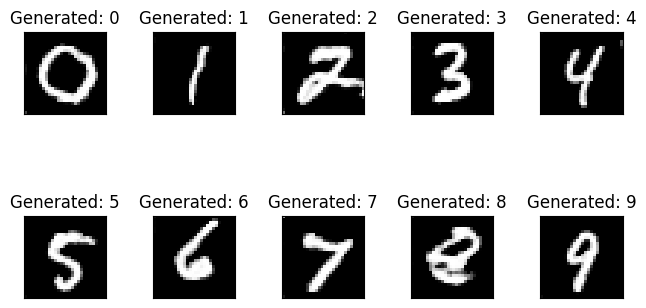

Real Discriminator Accuracy: 0.5728
Fake Discriminator Accuracy: 0.8341
Epoch 50, Noise 0.00257688760366006:


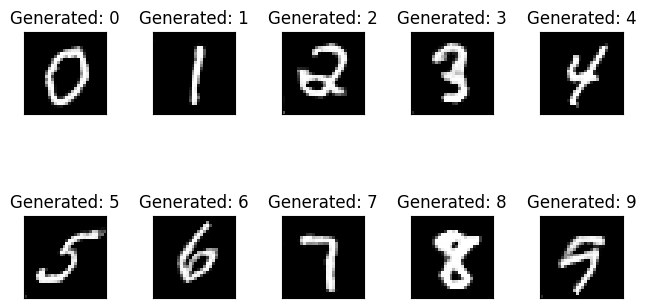

Real Discriminator Accuracy: 0.5527
Fake Discriminator Accuracy: 0.7627
Epoch 51, Noise 0.002319198843294054:


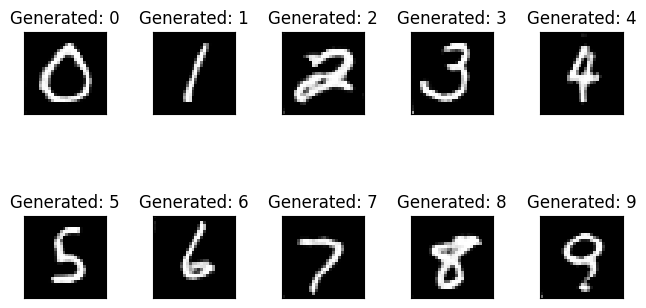

Real Discriminator Accuracy: 0.641
Fake Discriminator Accuracy: 0.816
Epoch 52, Noise 0.0020872789589646487:


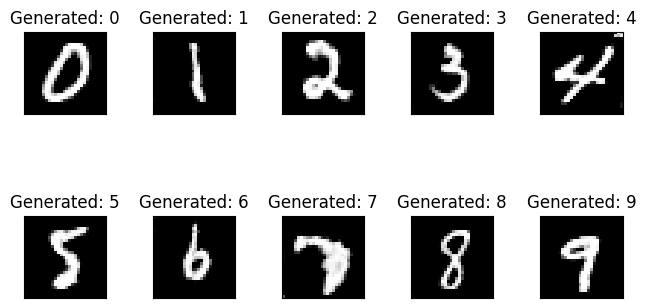

Real Discriminator Accuracy: 0.6177
Fake Discriminator Accuracy: 0.7606
Epoch 53, Noise 0.0018785510630681837:


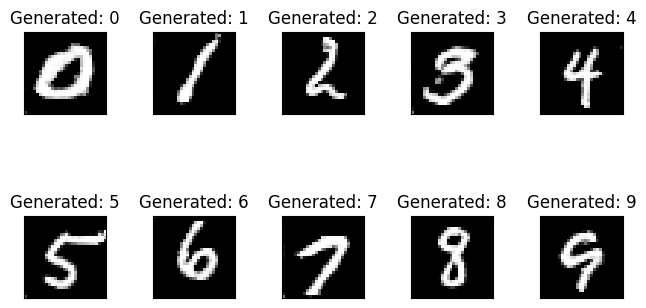

Real Discriminator Accuracy: 0.5913
Fake Discriminator Accuracy: 0.8288
Epoch 54, Noise 0.0016906959567613653:


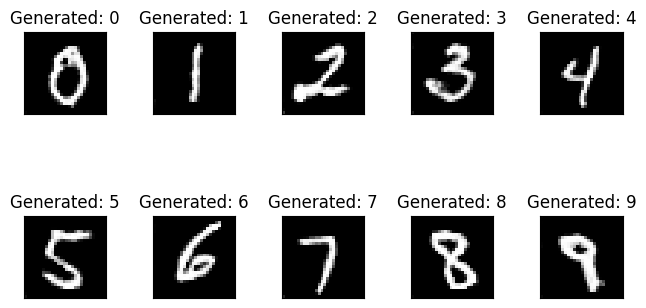

Real Discriminator Accuracy: 0.6728
Fake Discriminator Accuracy: 0.7299
Epoch 55, Noise 0.0015216263610852289:


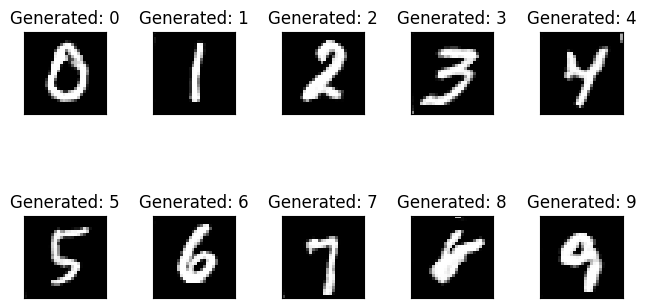

Real Discriminator Accuracy: 0.5022
Fake Discriminator Accuracy: 0.8448
Epoch 56, Noise 0.001369463724976706:


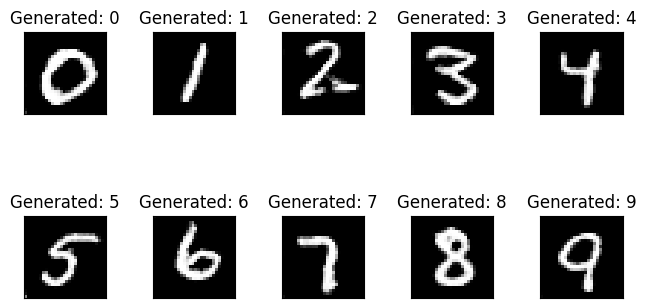

Real Discriminator Accuracy: 0.6485
Fake Discriminator Accuracy: 0.7515
Epoch 57, Noise 0.0012325173524790356:


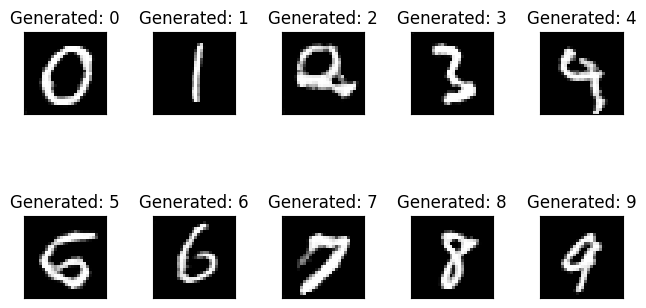

Real Discriminator Accuracy: 0.5738
Fake Discriminator Accuracy: 0.7597
Epoch 58, Noise 0.001109265617231132:


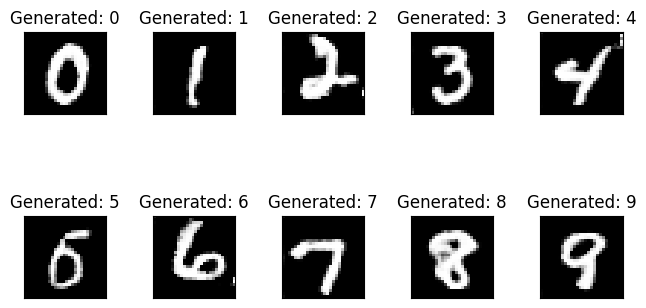

Real Discriminator Accuracy: 0.5134
Fake Discriminator Accuracy: 0.8722
Epoch 59, Noise 0.0009983390555080188:


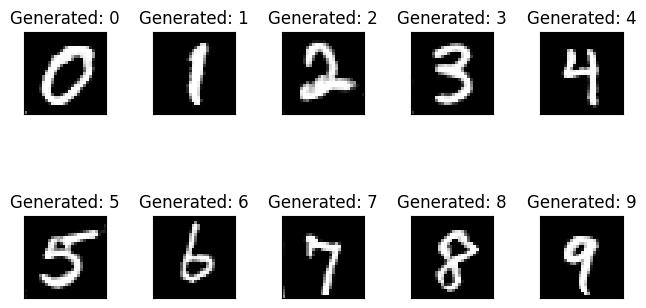

Real Discriminator Accuracy: 0.6581
Fake Discriminator Accuracy: 0.7201
Epoch 60, Noise 0.000898505149957217:


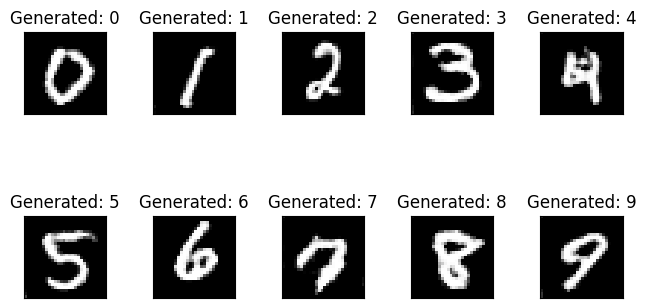

Real Discriminator Accuracy: 0.6582
Fake Discriminator Accuracy: 0.7077
Epoch 61, Noise 0.0008086546349614953:


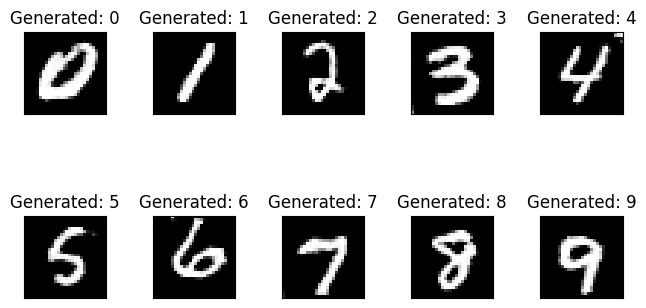

Real Discriminator Accuracy: 0.6668
Fake Discriminator Accuracy: 0.6856
Epoch 62, Noise 0.0007277891714653458:


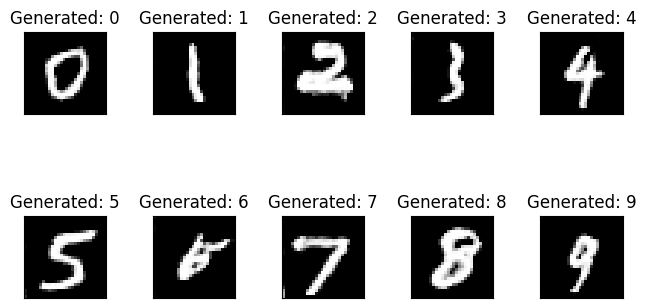

Real Discriminator Accuracy: 0.569
Fake Discriminator Accuracy: 0.7846
Epoch 63, Noise 0.0006550102543188112:


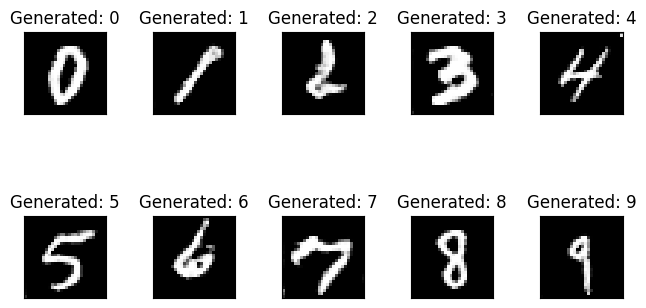

Real Discriminator Accuracy: 0.6881
Fake Discriminator Accuracy: 0.6725
Epoch 64, Noise 0.0005895092288869301:


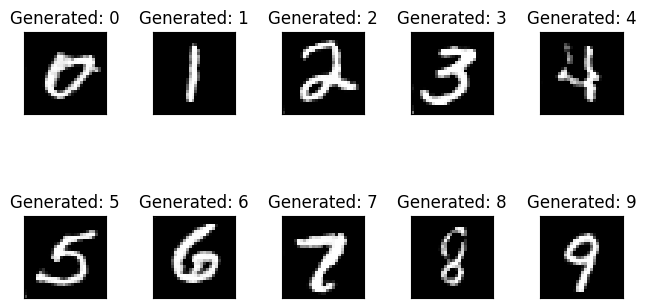

Real Discriminator Accuracy: 0.674
Fake Discriminator Accuracy: 0.7287
Epoch 65, Noise 0.000530558305998237:


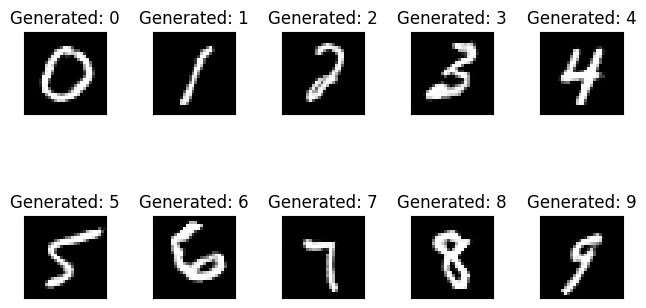

Real Discriminator Accuracy: 0.671
Fake Discriminator Accuracy: 0.6719
Epoch 66, Noise 0.0004775024753984134:


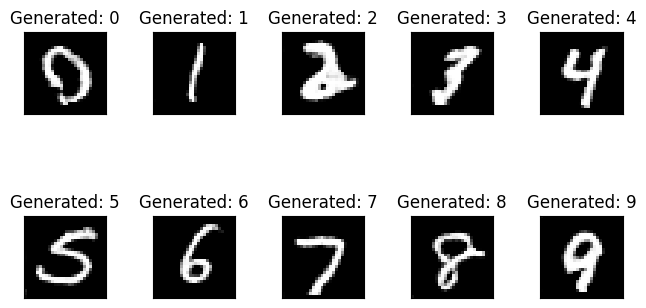

Real Discriminator Accuracy: 0.6526
Fake Discriminator Accuracy: 0.7052
Epoch 67, Noise 0.00042975222785857206:


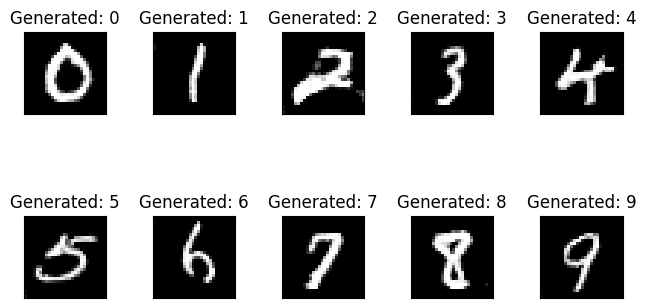

Real Discriminator Accuracy: 0.5742
Fake Discriminator Accuracy: 0.7836
Epoch 68, Noise 0.00038677700507271486:


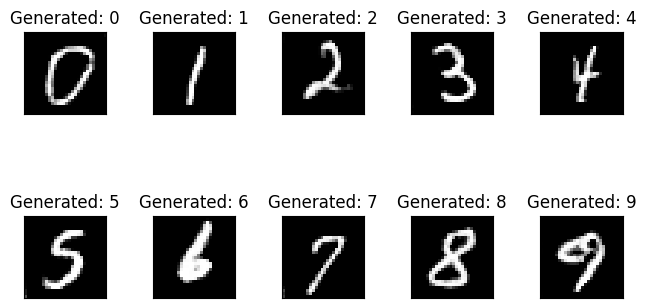

Real Discriminator Accuracy: 0.4889
Fake Discriminator Accuracy: 0.8653
Epoch 69, Noise 0.0003480993045654434:


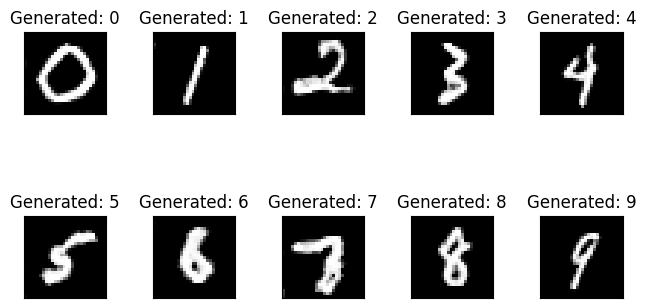

Real Discriminator Accuracy: 0.5688
Fake Discriminator Accuracy: 0.7915
Epoch 70, Noise 0.00031328937410889904:


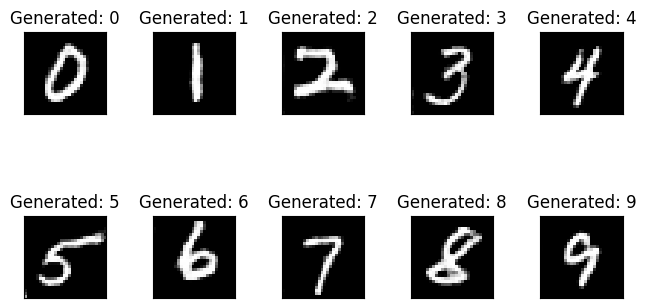

Real Discriminator Accuracy: 0.5554
Fake Discriminator Accuracy: 0.7902
Epoch 71, Noise 0.0002819604366980092:


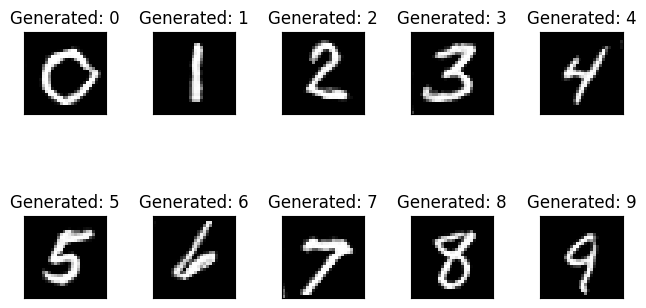

Real Discriminator Accuracy: 0.5668
Fake Discriminator Accuracy: 0.7092
Epoch 72, Noise 0.00025376439302820825:


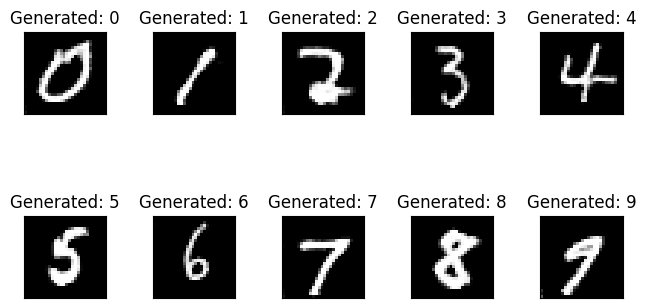

Real Discriminator Accuracy: 0.4568
Fake Discriminator Accuracy: 0.8597
Epoch 73, Noise 0.00022838795372538744:


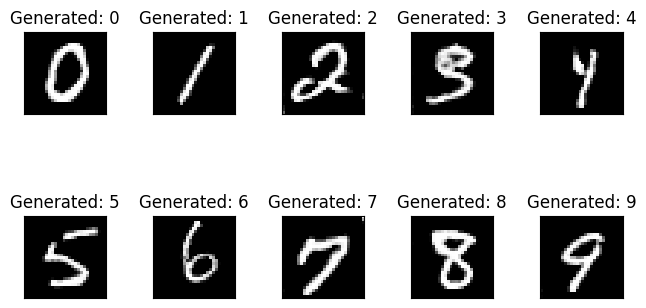

Real Discriminator Accuracy: 0.6376
Fake Discriminator Accuracy: 0.7318
Epoch 74, Noise 0.0002055491583528487:


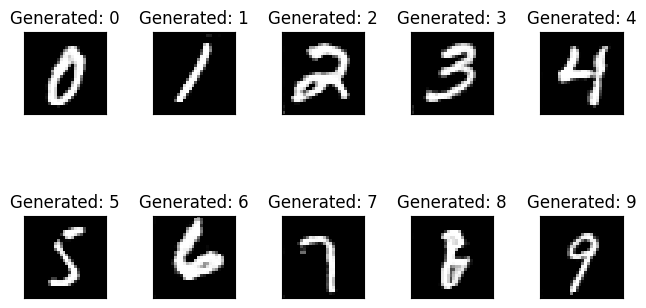

Real Discriminator Accuracy: 0.627
Fake Discriminator Accuracy: 0.7386
Epoch 75, Noise 0.00018499424251756382:


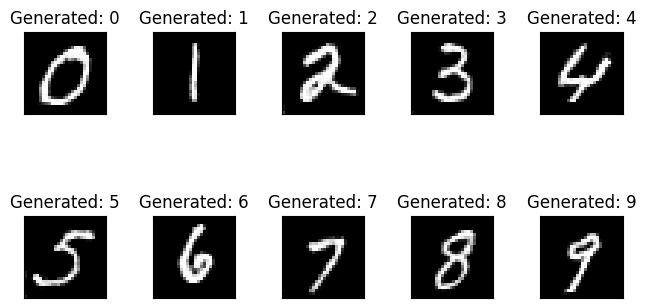

Real Discriminator Accuracy: 0.6583
Fake Discriminator Accuracy: 0.7489
Epoch 76, Noise 0.00016649481826580746:


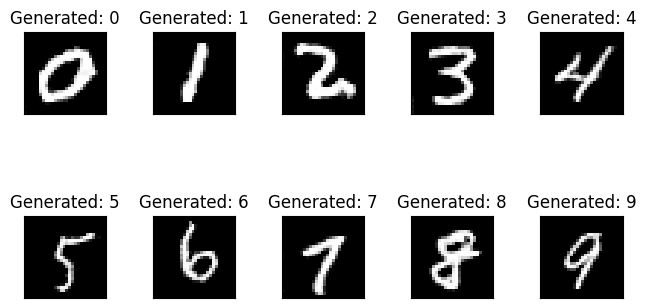

Real Discriminator Accuracy: 0.5482
Fake Discriminator Accuracy: 0.793
Epoch 77, Noise 0.0001498453364392267:


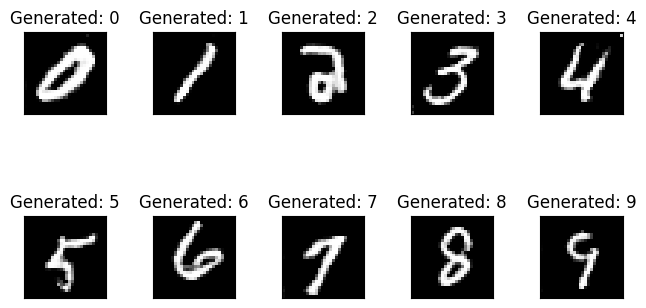

Real Discriminator Accuracy: 0.5963
Fake Discriminator Accuracy: 0.7539
Epoch 78, Noise 0.00013486080279530405:


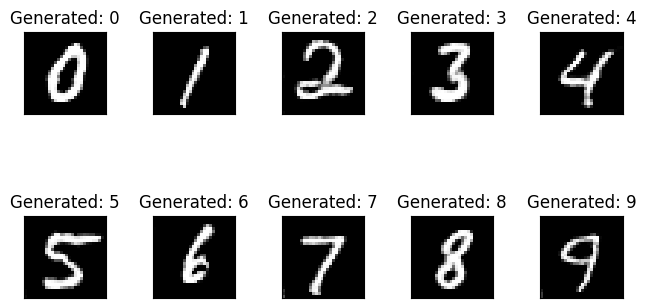

Real Discriminator Accuracy: 0.583
Fake Discriminator Accuracy: 0.8014
Epoch 79, Noise 0.00012137472251577364:


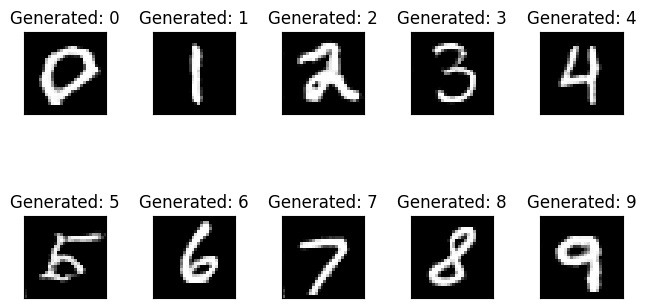

Real Discriminator Accuracy: 0.6062
Fake Discriminator Accuracy: 0.7565
Epoch 80, Noise 0.00010923725026419627:


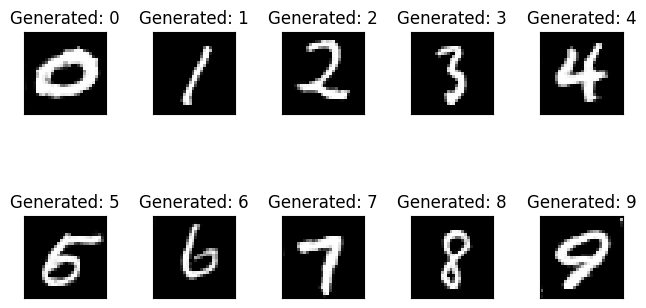

Real Discriminator Accuracy: 0.5847
Fake Discriminator Accuracy: 0.7576
Epoch 81, Noise 9.831352523777666e-05:


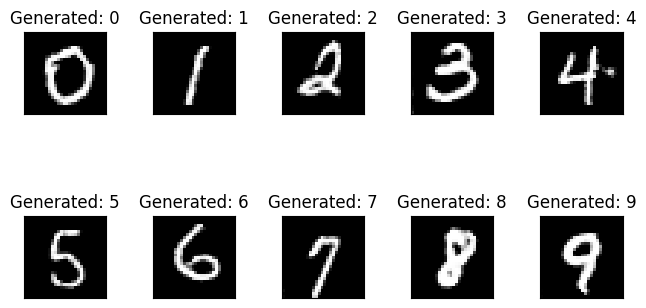

Real Discriminator Accuracy: 0.5809
Fake Discriminator Accuracy: 0.7794
Epoch 82, Noise 8.848217271399898e-05:


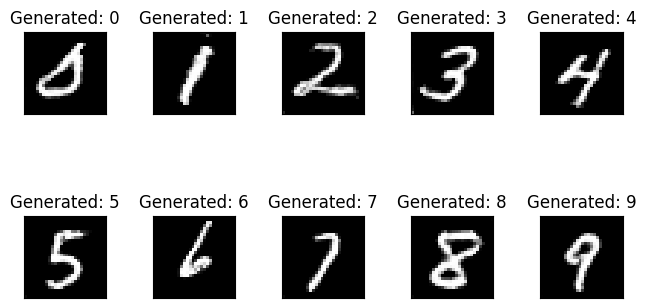

Real Discriminator Accuracy: 0.6223
Fake Discriminator Accuracy: 0.7861
Epoch 83, Noise 7.963395544259909e-05:


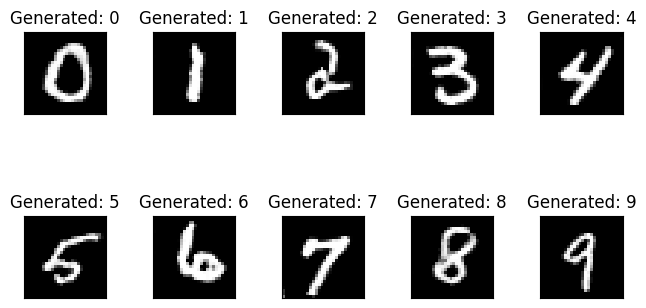

Real Discriminator Accuracy: 0.5041
Fake Discriminator Accuracy: 0.8366
Epoch 84, Noise 7.167055989833918e-05:


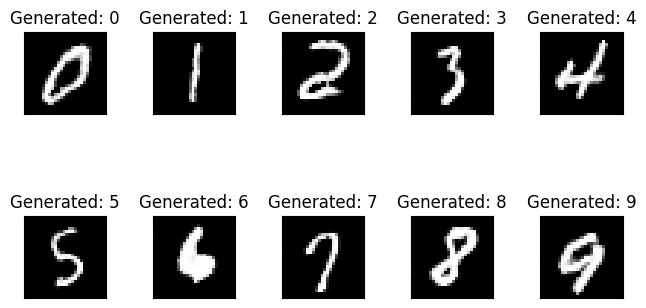

Real Discriminator Accuracy: 0.5011
Fake Discriminator Accuracy: 0.844
Epoch 85, Noise 6.450350390850527e-05:


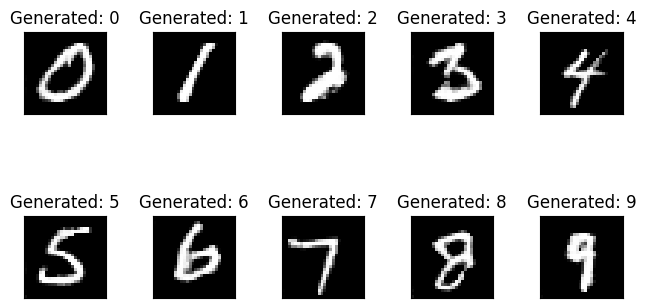

Real Discriminator Accuracy: 0.5511
Fake Discriminator Accuracy: 0.8053
Epoch 86, Noise 5.8053153517654746e-05:


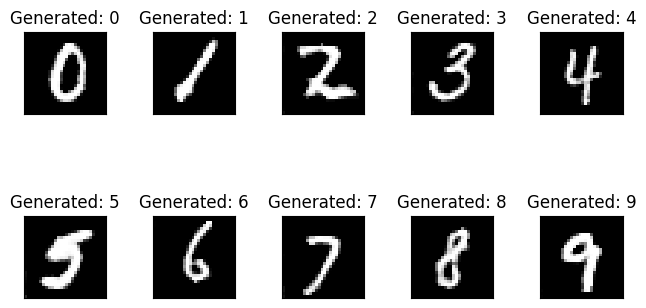

Real Discriminator Accuracy: 0.5884
Fake Discriminator Accuracy: 0.7504
Epoch 87, Noise 5.224783816588927e-05:


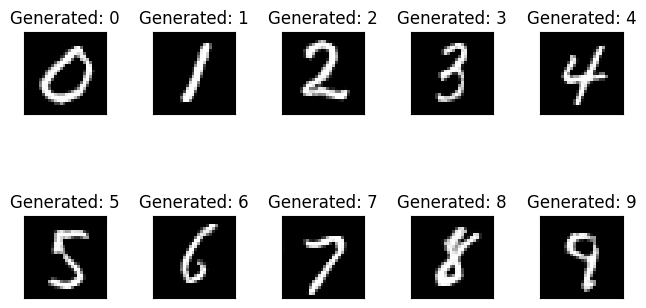

Real Discriminator Accuracy: 0.5372
Fake Discriminator Accuracy: 0.816
Epoch 88, Noise 4.702305434930034e-05:


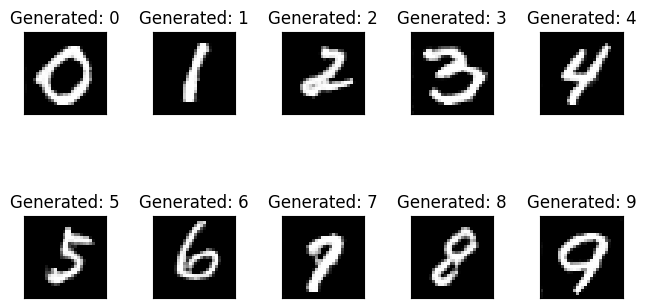

Real Discriminator Accuracy: 0.5602
Fake Discriminator Accuracy: 0.7981
Epoch 89, Noise 4.232074891437031e-05:


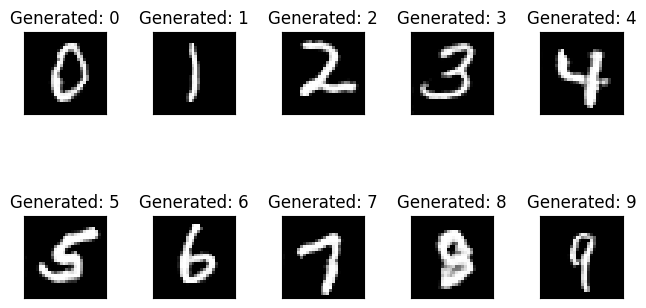

Real Discriminator Accuracy: 0.6332
Fake Discriminator Accuracy: 0.7244
Epoch 90, Noise 3.8088674022933284e-05:


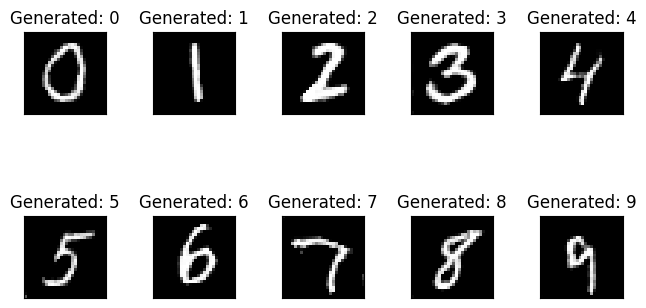

Real Discriminator Accuracy: 0.4999
Fake Discriminator Accuracy: 0.8227
Epoch 91, Noise 3.427980662063995e-05:


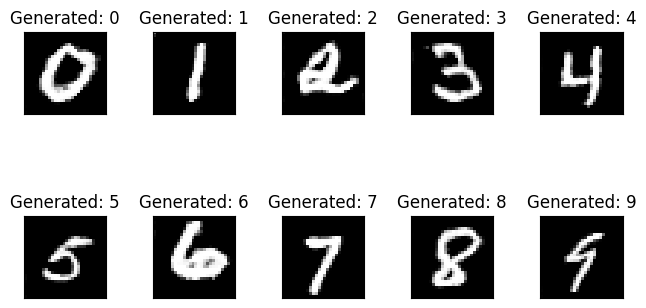

Real Discriminator Accuracy: 0.59
Fake Discriminator Accuracy: 0.7558
Epoch 92, Noise 3.085182595857596e-05:


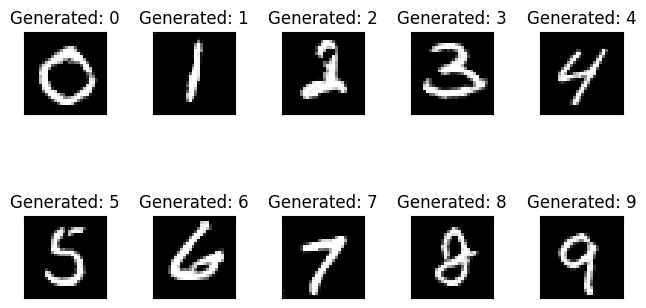

Real Discriminator Accuracy: 0.5396
Fake Discriminator Accuracy: 0.8142
Epoch 93, Noise 2.7766643362718363e-05:


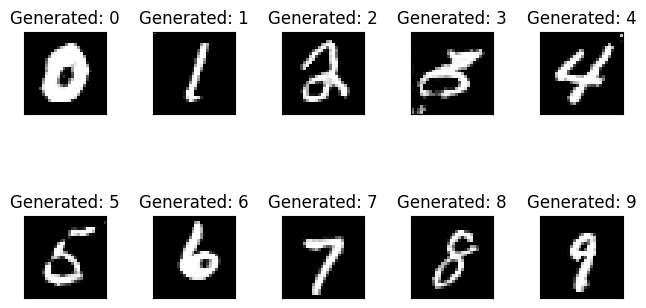

Real Discriminator Accuracy: 0.5866
Fake Discriminator Accuracy: 0.7646
Epoch 94, Noise 2.498997902644653e-05:


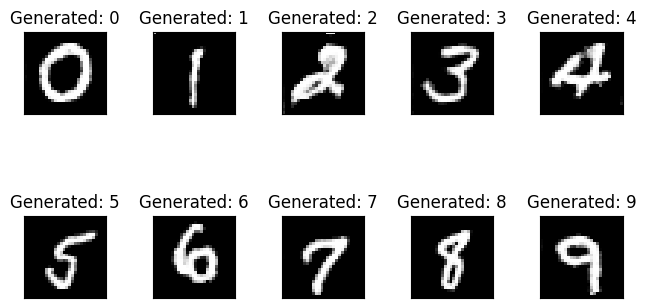

Real Discriminator Accuracy: 0.6206
Fake Discriminator Accuracy: 0.7247
Epoch 95, Noise 2.2490981123801875e-05:


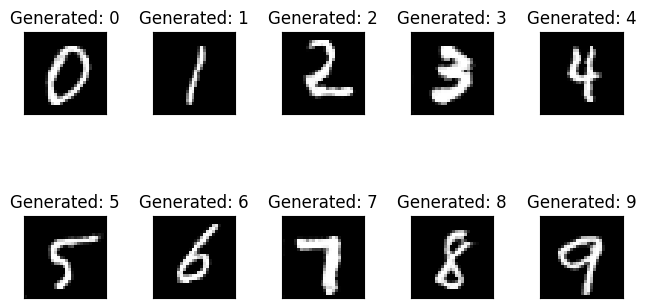

Real Discriminator Accuracy: 0.5778
Fake Discriminator Accuracy: 0.7877
Epoch 96, Noise 2.0241883011421687e-05:


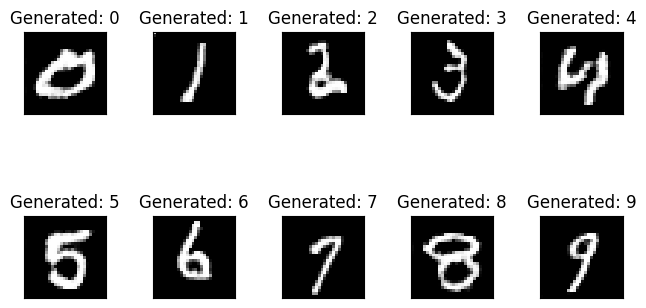

Real Discriminator Accuracy: 0.5686
Fake Discriminator Accuracy: 0.7731
Epoch 97, Noise 1.821769471027952e-05:


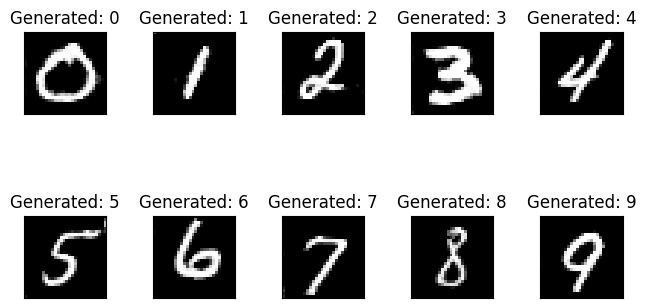

Real Discriminator Accuracy: 0.6161
Fake Discriminator Accuracy: 0.7273
Epoch 98, Noise 1.639592523925157e-05:


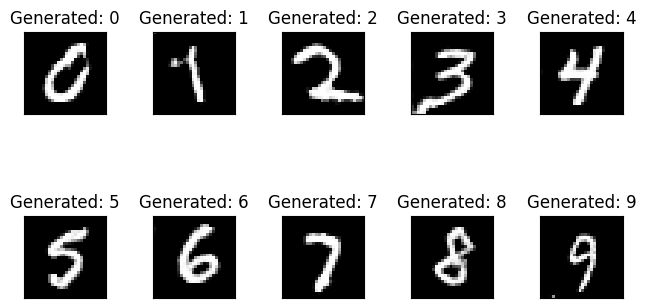

Real Discriminator Accuracy: 0.5858
Fake Discriminator Accuracy: 0.7653
Epoch 99, Noise 1.4756332715326412e-05:


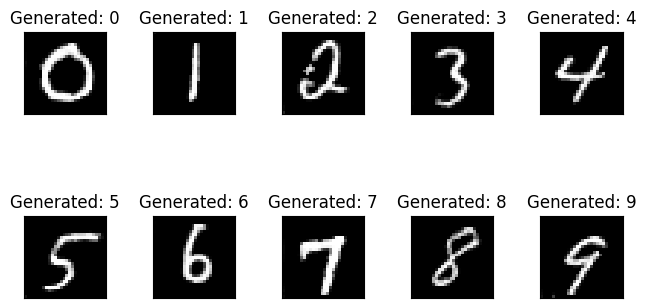

Real Discriminator Accuracy: 0.6544
Fake Discriminator Accuracy: 0.7076
Epoch 100, Noise 1.3280699443793772e-05:


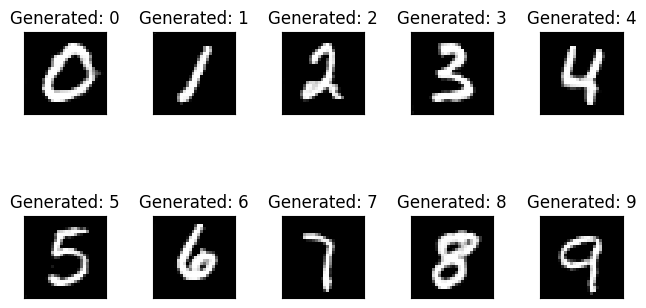

Real Discriminator Accuracy: 0.6687
Fake Discriminator Accuracy: 0.675
Epoch 101, Noise 1.1952629499414394e-05:


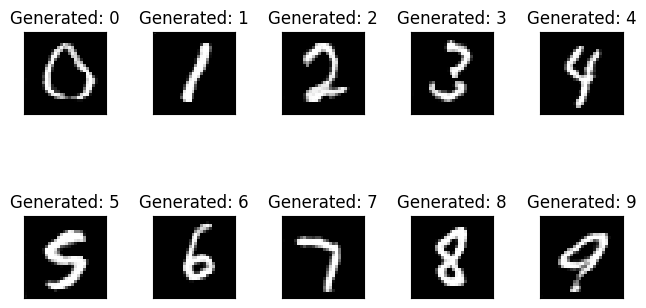

Real Discriminator Accuracy: 0.6489
Fake Discriminator Accuracy: 0.7112
Epoch 102, Noise 1.0757366549472955e-05:


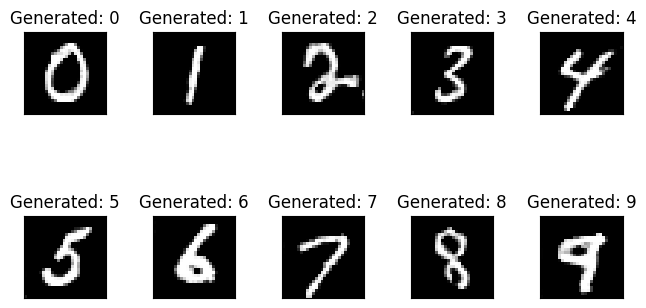

Real Discriminator Accuracy: 0.4565
Fake Discriminator Accuracy: 0.8675
Epoch 103, Noise 9.68162989452566e-06:


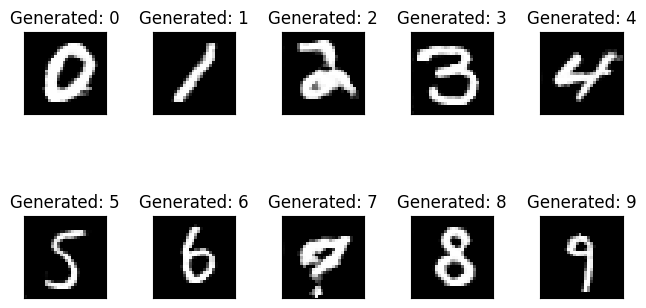

Real Discriminator Accuracy: 0.6012
Fake Discriminator Accuracy: 0.7357
Epoch 104, Noise 8.713466905073094e-06:


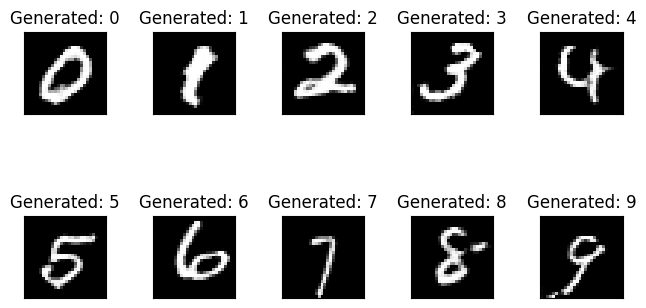

Real Discriminator Accuracy: 0.5367
Fake Discriminator Accuracy: 0.7889
Epoch 105, Noise 7.842120214565786e-06:


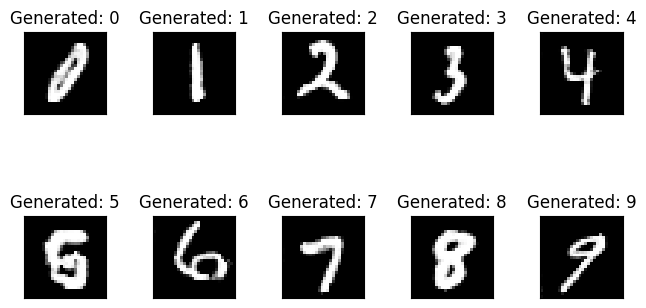

Real Discriminator Accuracy: 0.5563
Fake Discriminator Accuracy: 0.7779
Epoch 106, Noise 7.0579081931092065e-06:


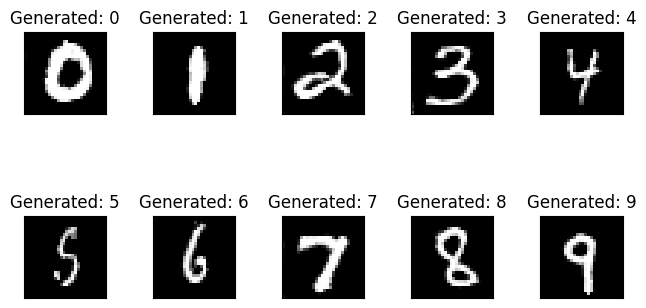

Real Discriminator Accuracy: 0.6077
Fake Discriminator Accuracy: 0.7254
Epoch 107, Noise 6.352117373798286e-06:


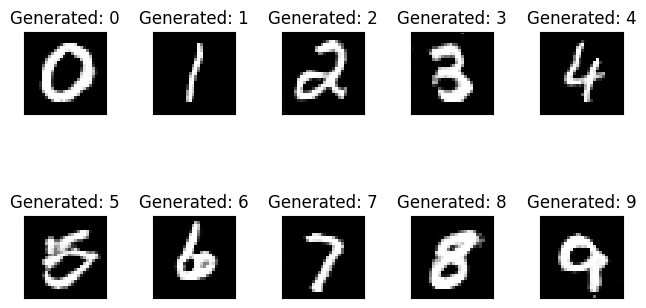

Real Discriminator Accuracy: 0.6231
Fake Discriminator Accuracy: 0.7149
Epoch 108, Noise 5.716905636418458e-06:


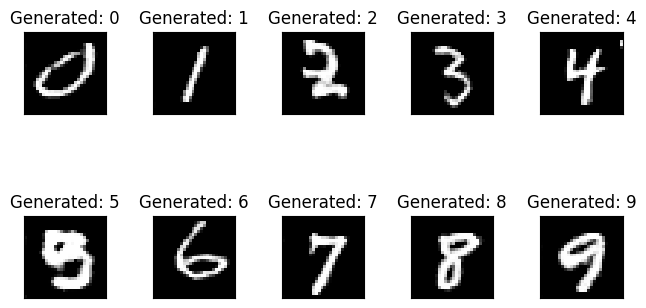

Real Discriminator Accuracy: 0.5956
Fake Discriminator Accuracy: 0.7495
Epoch 109, Noise 5.145215072776612e-06:


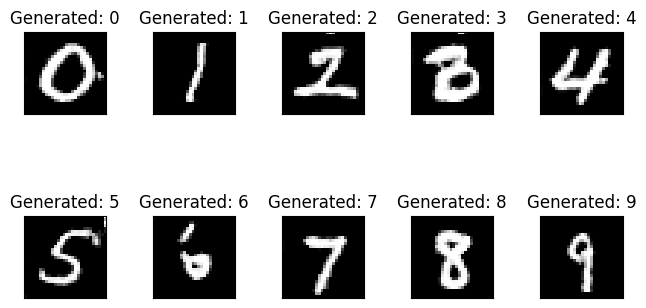

Real Discriminator Accuracy: 0.5172
Fake Discriminator Accuracy: 0.8217
Epoch 110, Noise 4.6306935654989505e-06:


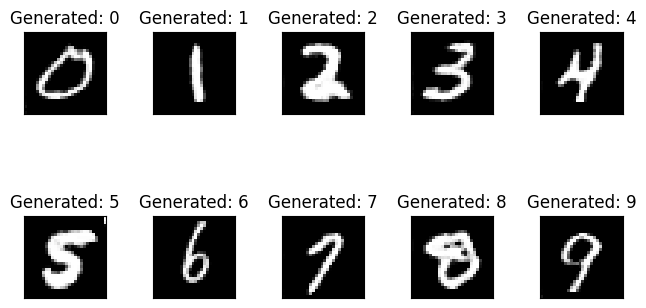

Real Discriminator Accuracy: 0.4743
Fake Discriminator Accuracy: 0.8481
Epoch 111, Noise 4.167624208949056e-06:


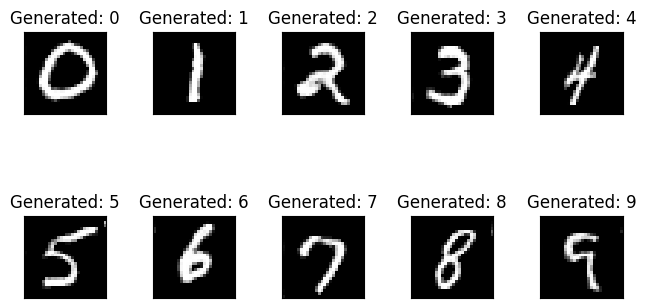

Real Discriminator Accuracy: 0.5573
Fake Discriminator Accuracy: 0.7787
Epoch 112, Noise 3.7508617880541506e-06:


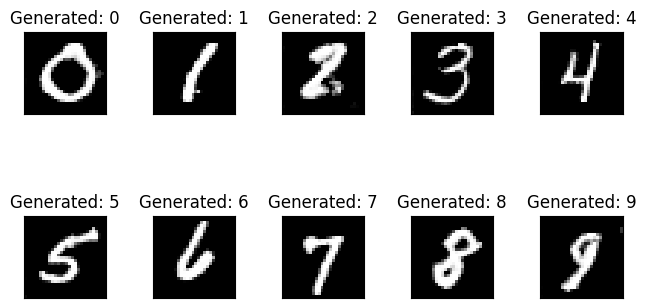

Real Discriminator Accuracy: 0.5252
Fake Discriminator Accuracy: 0.8258
Epoch 113, Noise 3.3757756092487353e-06:


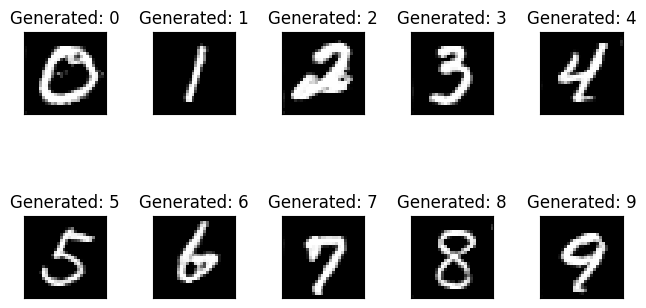

Real Discriminator Accuracy: 0.5286
Fake Discriminator Accuracy: 0.8026
Epoch 114, Noise 3.038198048323862e-06:


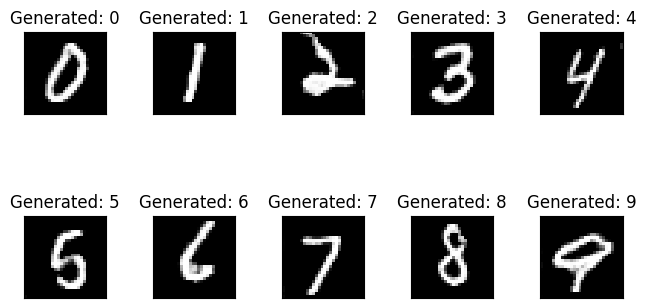

Real Discriminator Accuracy: 0.6015
Fake Discriminator Accuracy: 0.7398
Epoch 115, Noise 2.734378243491476e-06:


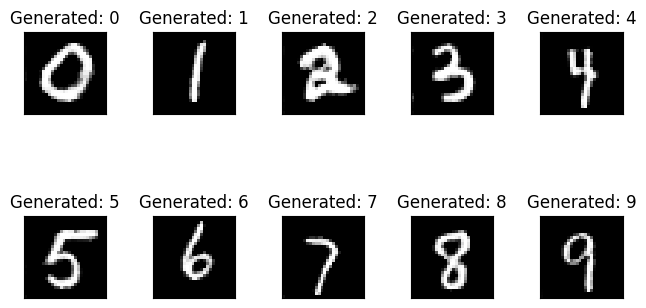

Real Discriminator Accuracy: 0.6733
Fake Discriminator Accuracy: 0.6686
Epoch 116, Noise 2.4609404191423284e-06:


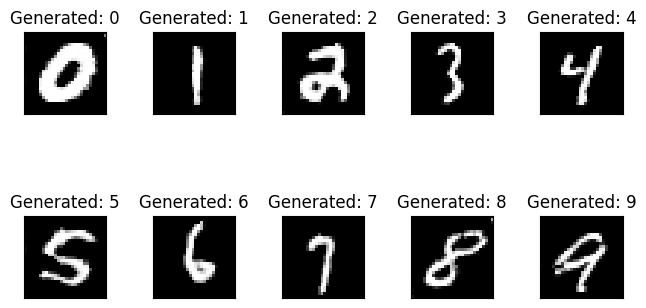

Real Discriminator Accuracy: 0.5375
Fake Discriminator Accuracy: 0.7885
Epoch 117, Noise 2.2148463772280958e-06:


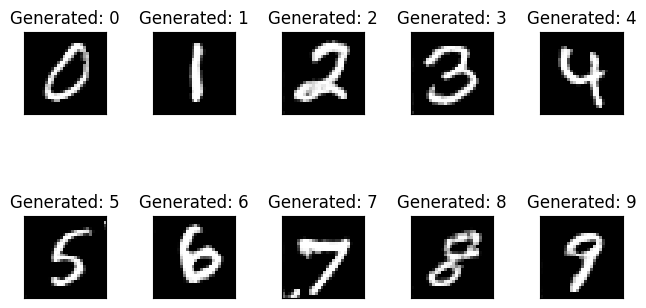

Real Discriminator Accuracy: 0.4898
Fake Discriminator Accuracy: 0.819
Epoch 118, Noise 1.993361739505286e-06:


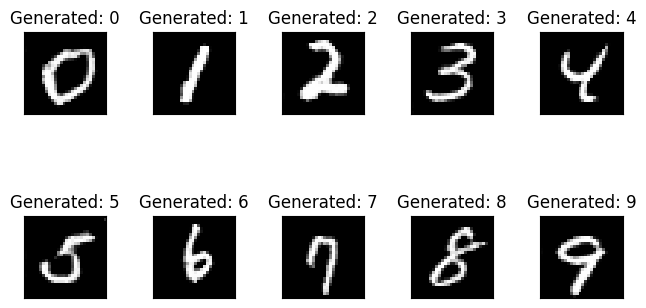

Real Discriminator Accuracy: 0.588
Fake Discriminator Accuracy: 0.7425
Epoch 119, Noise 1.7940255655547574e-06:


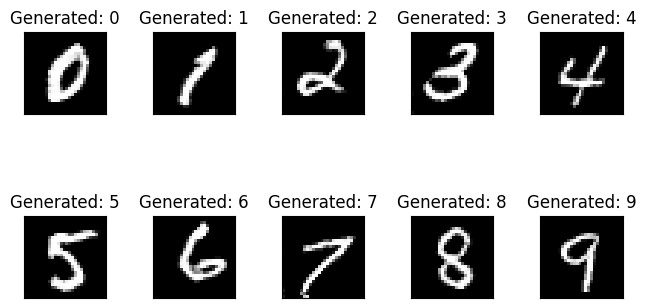

Real Discriminator Accuracy: 0.5489
Fake Discriminator Accuracy: 0.7742
Epoch 120, Noise 1.6146230089992818e-06:


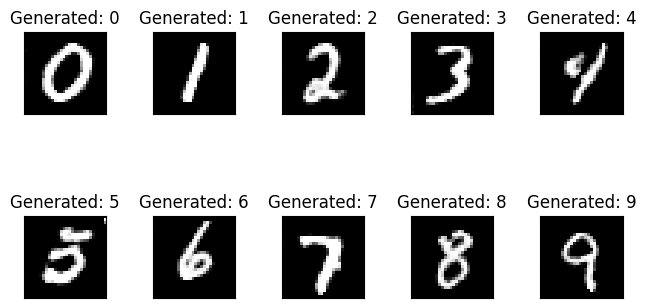

Real Discriminator Accuracy: 0.6484
Fake Discriminator Accuracy: 0.6762
Epoch 121, Noise 1.4531607080993537e-06:


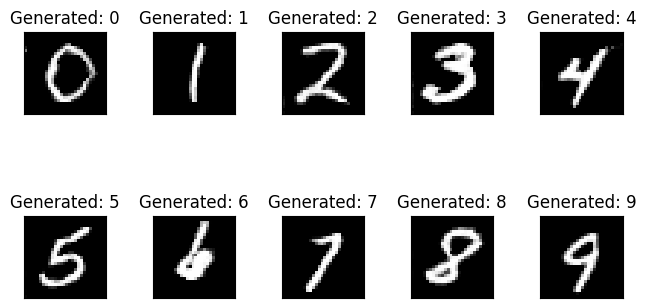

Real Discriminator Accuracy: 0.4854
Fake Discriminator Accuracy: 0.8381
Epoch 122, Noise 1.3078446372894183e-06:


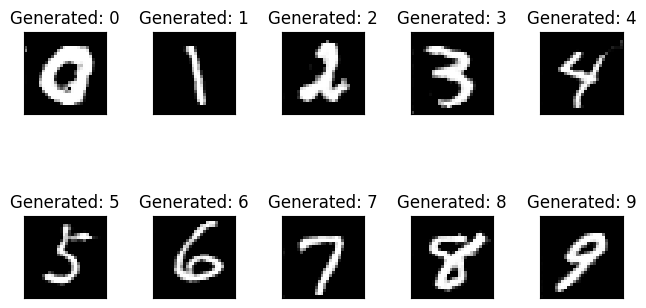

Real Discriminator Accuracy: 0.5185
Fake Discriminator Accuracy: 0.8241
Epoch 123, Noise 1.1770601735604766e-06:


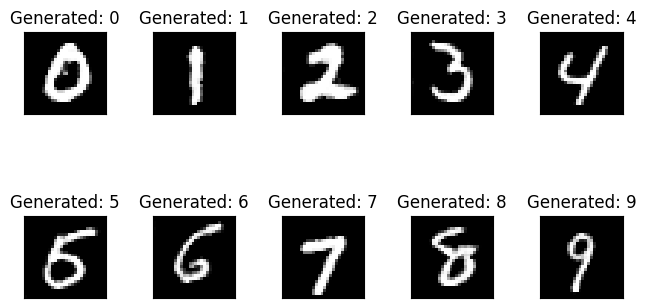

Real Discriminator Accuracy: 0.5976
Fake Discriminator Accuracy: 0.7405
Epoch 124, Noise 1.059354156204429e-06:


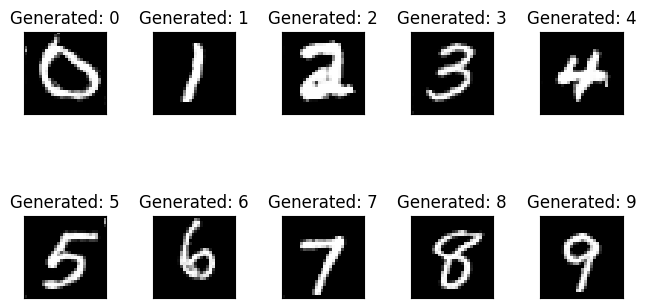

Real Discriminator Accuracy: 0.5771
Fake Discriminator Accuracy: 0.7499
Epoch 125, Noise 9.53418740583986e-07:


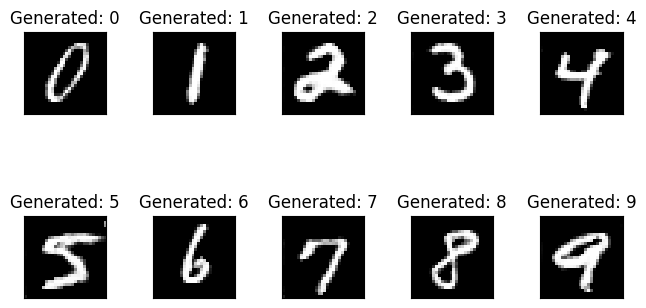

Real Discriminator Accuracy: 0.4697
Fake Discriminator Accuracy: 0.8489
Epoch 126, Noise 8.580768665255875e-07:


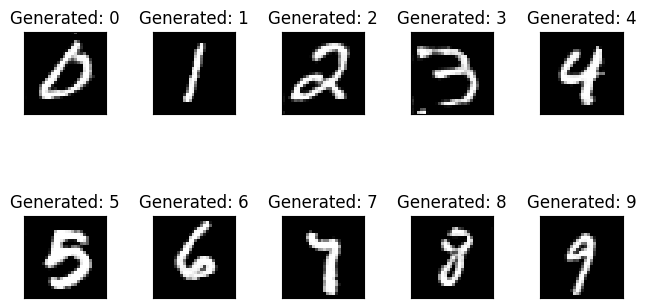

Real Discriminator Accuracy: 0.5583
Fake Discriminator Accuracy: 0.7696
Epoch 127, Noise 7.722691798730287e-07:


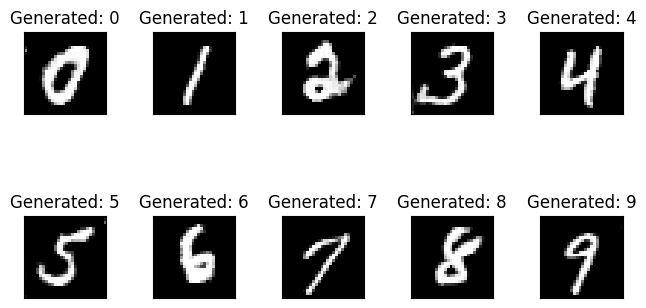

Real Discriminator Accuracy: 0.6038
Fake Discriminator Accuracy: 0.7069
Epoch 128, Noise 6.950422618857258e-07:


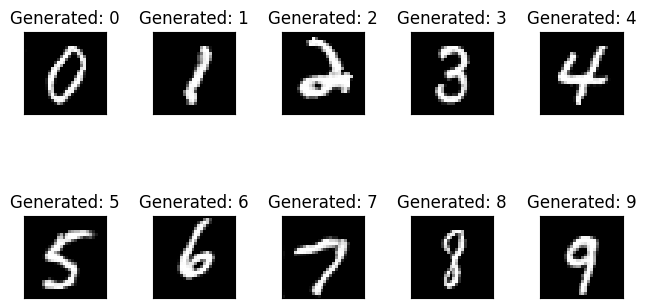

Real Discriminator Accuracy: 0.5355
Fake Discriminator Accuracy: 0.7888
Epoch 129, Noise 6.255380356971533e-07:


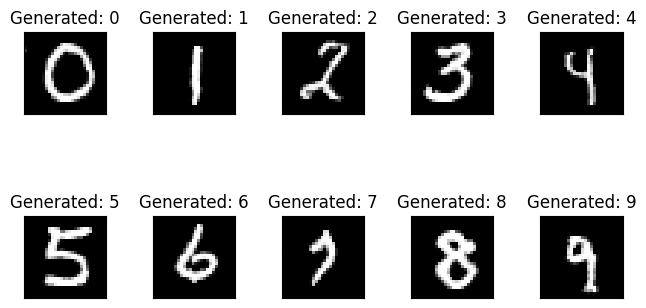

Real Discriminator Accuracy: 0.6339
Fake Discriminator Accuracy: 0.6947
Epoch 130, Noise 5.629842321274379e-07:


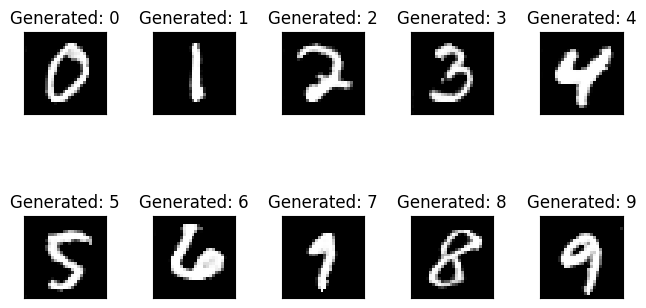

Real Discriminator Accuracy: 0.4745
Fake Discriminator Accuracy: 0.85
Epoch 131, Noise 5.066858089146942e-07:


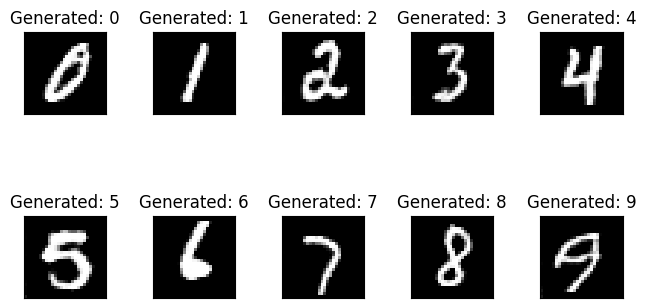

Real Discriminator Accuracy: 0.5865
Fake Discriminator Accuracy: 0.7536
Epoch 132, Noise 4.560172280232248e-07:


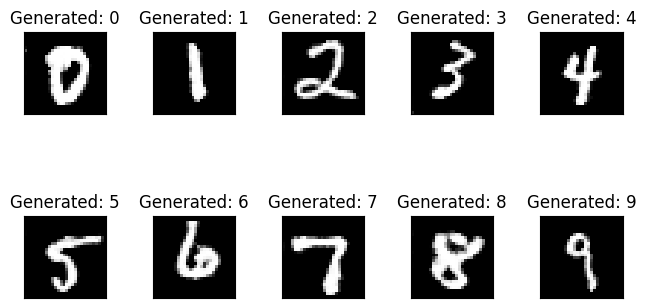

Real Discriminator Accuracy: 0.5223
Fake Discriminator Accuracy: 0.8104
Epoch 133, Noise 4.104155052209023e-07:


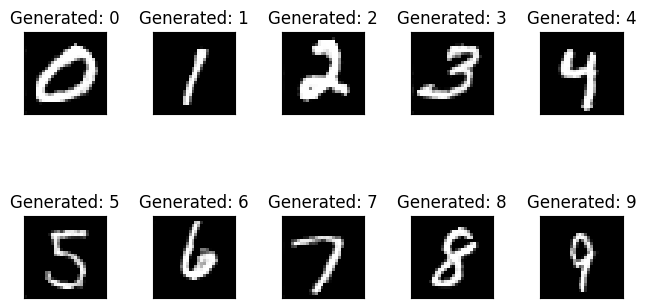

Real Discriminator Accuracy: 0.551
Fake Discriminator Accuracy: 0.7883
Epoch 134, Noise 3.693739546988121e-07:


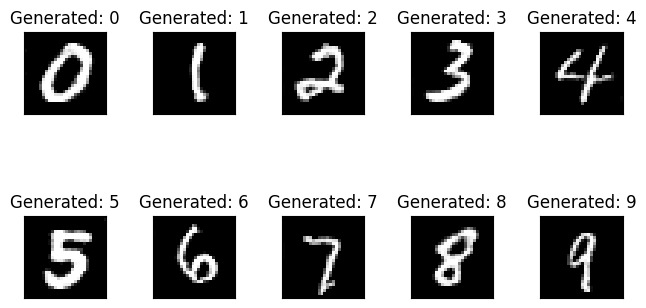

Real Discriminator Accuracy: 0.5611
Fake Discriminator Accuracy: 0.7678
Epoch 135, Noise 3.3243655922893087e-07:


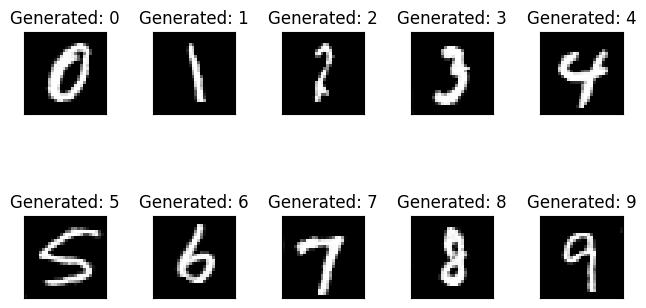

Real Discriminator Accuracy: 0.546
Fake Discriminator Accuracy: 0.7786
Epoch 136, Noise 2.991929033060378e-07:


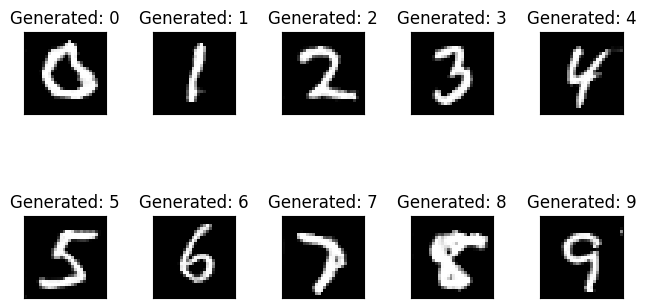

Real Discriminator Accuracy: 0.5217
Fake Discriminator Accuracy: 0.8023
Epoch 137, Noise 2.6927361297543404e-07:


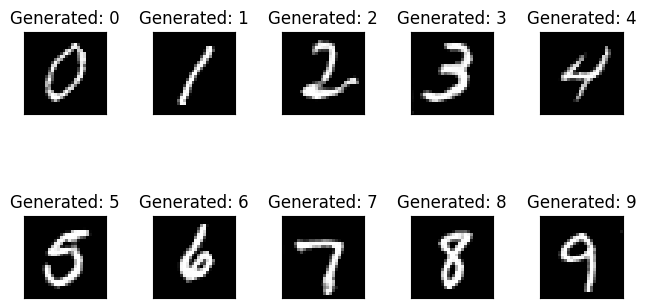

Real Discriminator Accuracy: 0.533
Fake Discriminator Accuracy: 0.7982
Epoch 138, Noise 2.4234625167789063e-07:


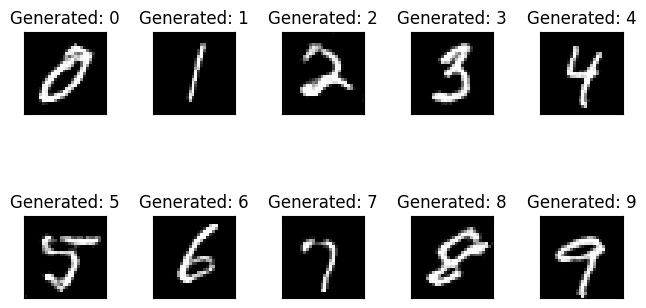

Real Discriminator Accuracy: 0.563
Fake Discriminator Accuracy: 0.7792
Epoch 139, Noise 2.1811162651010157e-07:


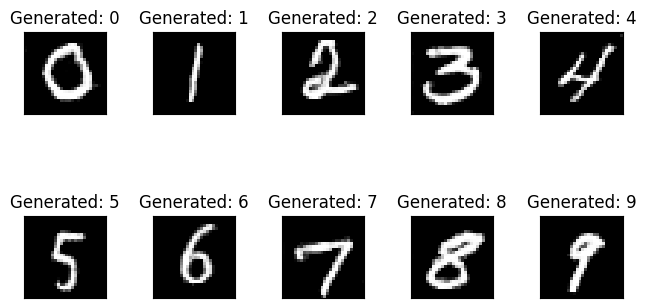

Real Discriminator Accuracy: 0.4908
Fake Discriminator Accuracy: 0.8304
Epoch 140, Noise 1.9630046385909143e-07:


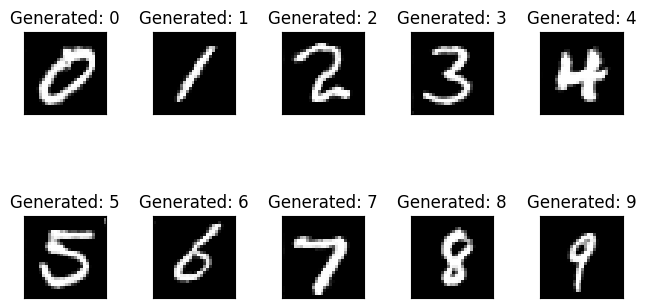

Real Discriminator Accuracy: 0.4693
Fake Discriminator Accuracy: 0.847
Epoch 141, Noise 1.766704174731823e-07:


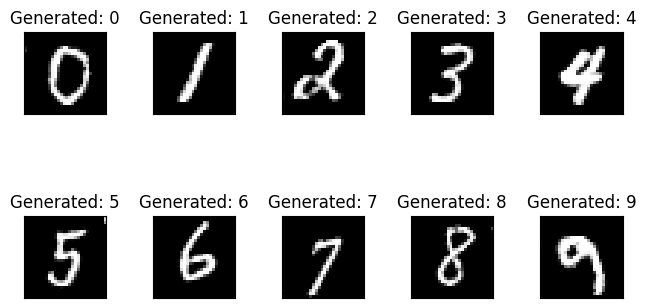

Real Discriminator Accuracy: 0.5245
Fake Discriminator Accuracy: 0.7968
Epoch 142, Noise 1.5900337572586406e-07:


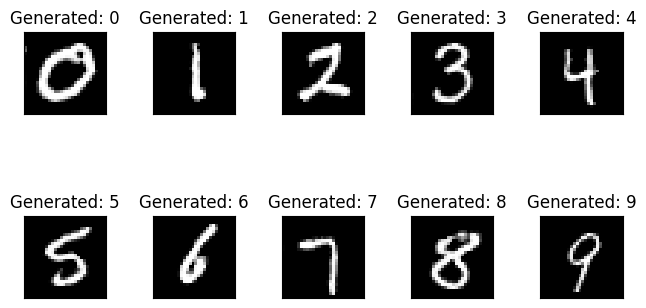

Real Discriminator Accuracy: 0.4992
Fake Discriminator Accuracy: 0.8105
Epoch 143, Noise 1.4310303815327767e-07:


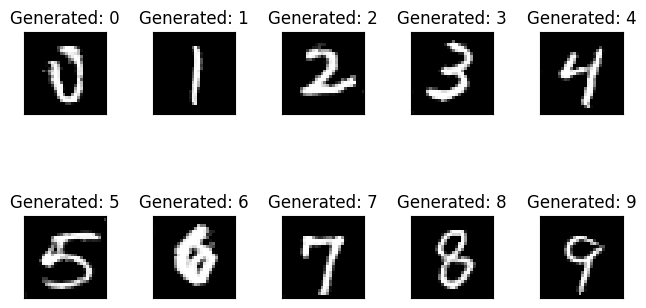

Real Discriminator Accuracy: 0.5388
Fake Discriminator Accuracy: 0.7808
Epoch 144, Noise 1.287927343379499e-07:


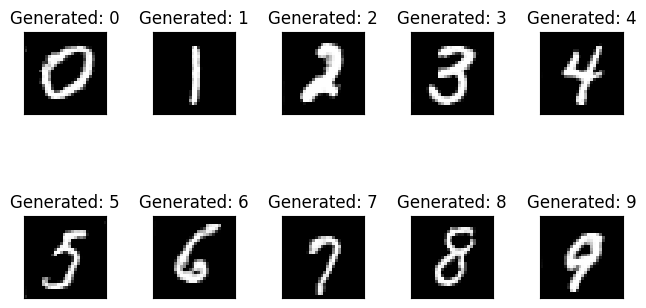

Real Discriminator Accuracy: 0.6543
Fake Discriminator Accuracy: 0.6623
Epoch 145, Noise 1.159134609041549e-07:


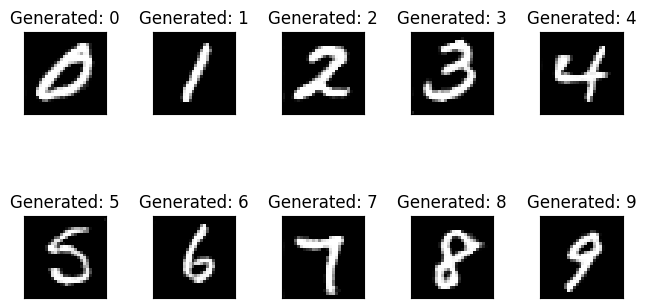

Real Discriminator Accuracy: 0.498
Fake Discriminator Accuracy: 0.8101
Epoch 146, Noise 1.0432211481373942e-07:


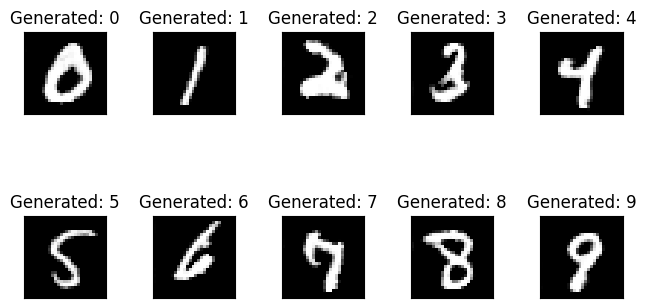

Real Discriminator Accuracy: 0.5143
Fake Discriminator Accuracy: 0.8103
Epoch 147, Noise 9.388990333236548e-08:


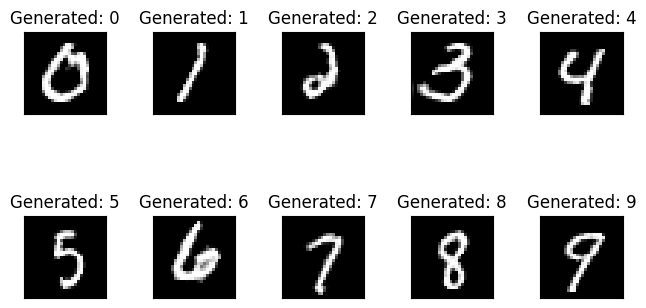

Real Discriminator Accuracy: 0.5052
Fake Discriminator Accuracy: 0.8173
Epoch 148, Noise 8.450091299912893e-08:


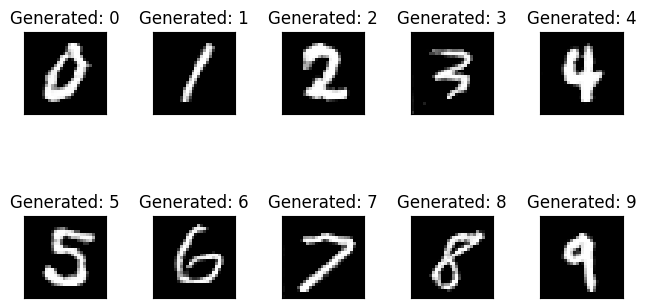

Real Discriminator Accuracy: 0.5212
Fake Discriminator Accuracy: 0.7929
Epoch 149, Noise 7.605082169921605e-08:


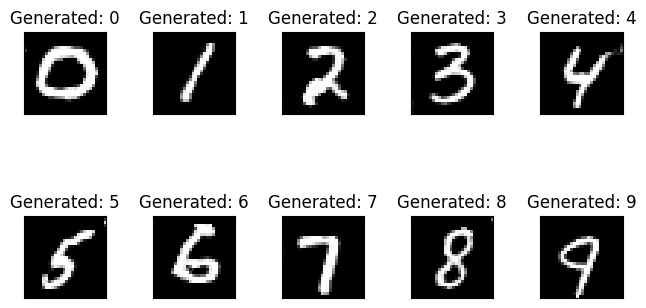

Real Discriminator Accuracy: 0.492
Fake Discriminator Accuracy: 0.8084
Epoch 150, Noise 6.844573952929445e-08:


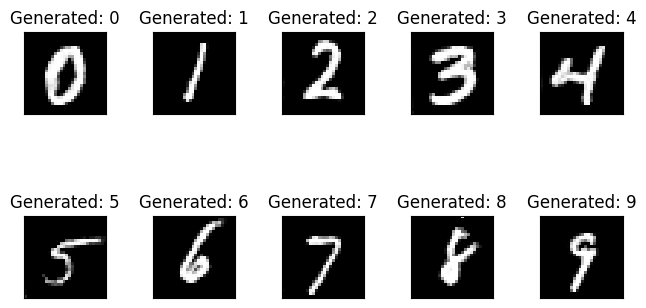

Real Discriminator Accuracy: 0.5413
Fake Discriminator Accuracy: 0.7771
Epoch 151, Noise 6.1601165576365e-08:


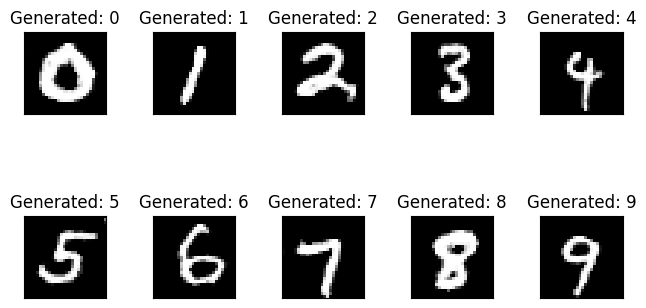

Real Discriminator Accuracy: 0.5249
Fake Discriminator Accuracy: 0.8011
Epoch 152, Noise 5.54410490187285e-08:


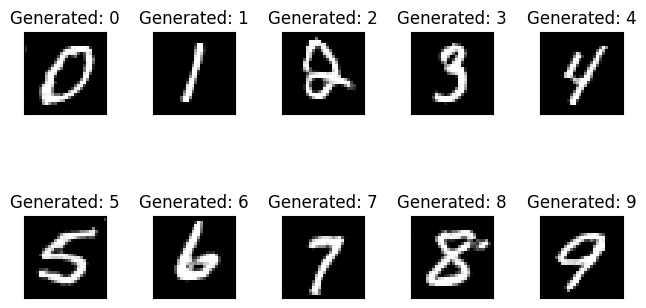

Real Discriminator Accuracy: 0.5301
Fake Discriminator Accuracy: 0.7916
Epoch 153, Noise 4.989694411685565e-08:


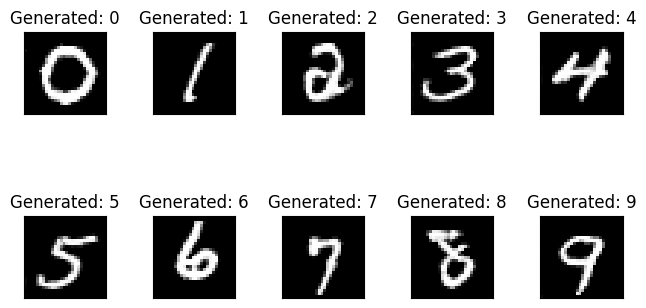

Real Discriminator Accuracy: 0.5601
Fake Discriminator Accuracy: 0.7591
Epoch 154, Noise 4.4907249705170086e-08:


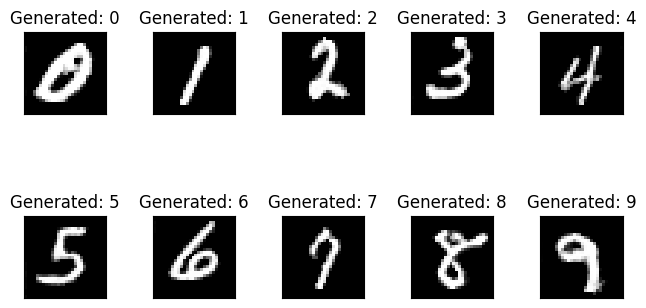

Real Discriminator Accuracy: 0.5679
Fake Discriminator Accuracy: 0.7557
Epoch 155, Noise 4.041652473465308e-08:


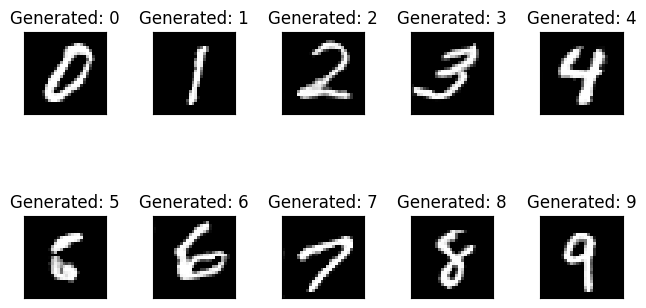

Real Discriminator Accuracy: 0.5791
Fake Discriminator Accuracy: 0.7503
Epoch 156, Noise 3.637487226118777e-08:


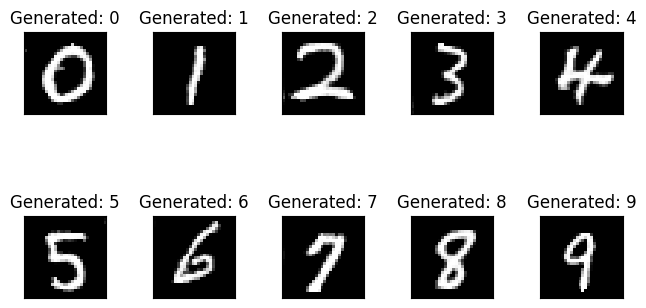

Real Discriminator Accuracy: 0.4609
Fake Discriminator Accuracy: 0.8552
Epoch 157, Noise 3.2737385035068995e-08:


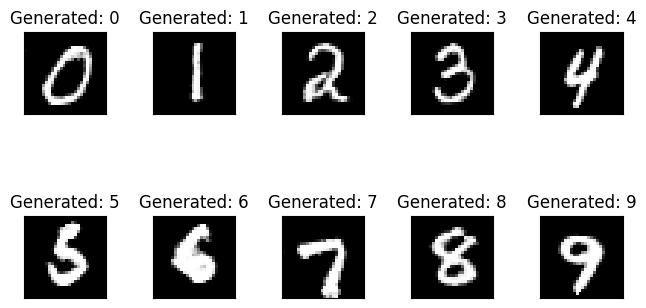

Real Discriminator Accuracy: 0.5818
Fake Discriminator Accuracy: 0.7192
Epoch 158, Noise 2.94636465315621e-08:


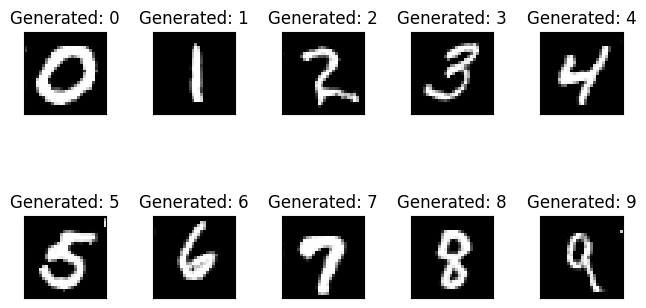

Real Discriminator Accuracy: 0.5121
Fake Discriminator Accuracy: 0.7947
Epoch 159, Noise 2.6517281878405888e-08:


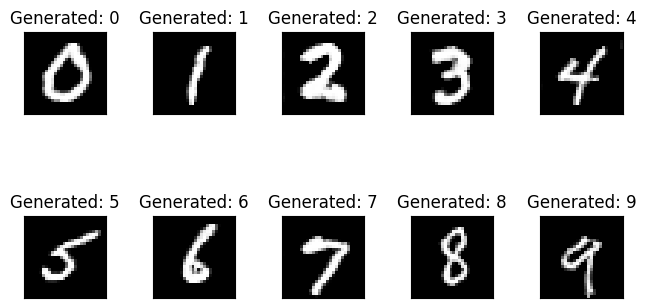

Real Discriminator Accuracy: 0.5835
Fake Discriminator Accuracy: 0.7323
Epoch 160, Noise 2.38655536905653e-08:


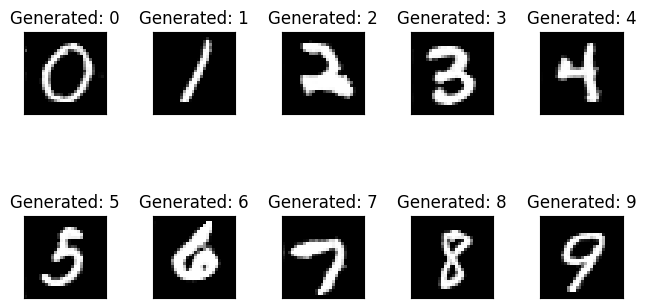

Real Discriminator Accuracy: 0.4969
Fake Discriminator Accuracy: 0.8207
Epoch 161, Noise 2.147899832150877e-08:


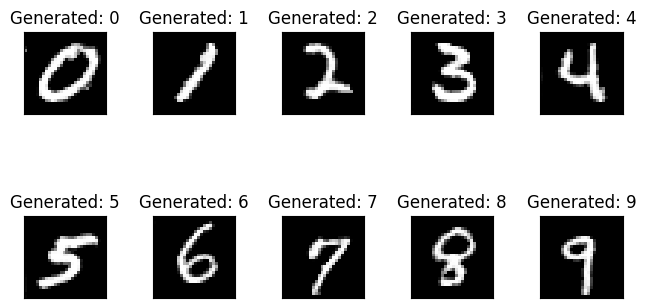

Real Discriminator Accuracy: 0.5238
Fake Discriminator Accuracy: 0.7911
Epoch 162, Noise 1.9331098489357894e-08:


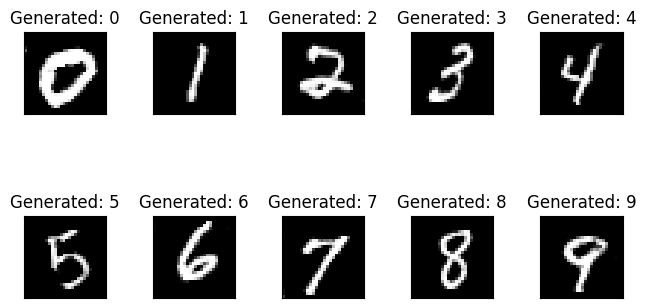

Real Discriminator Accuracy: 0.508
Fake Discriminator Accuracy: 0.7999
Epoch 163, Noise 1.7397988640422104e-08:


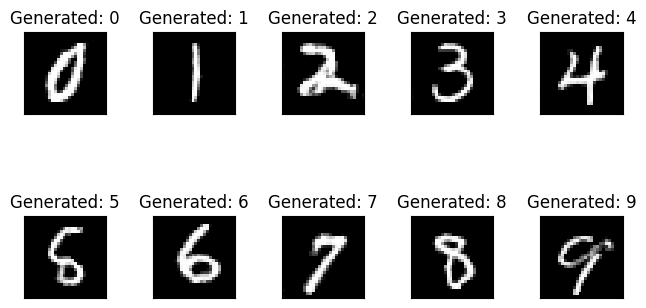

Real Discriminator Accuracy: 0.4914
Fake Discriminator Accuracy: 0.8115
Epoch 164, Noise 1.5658189776379895e-08:


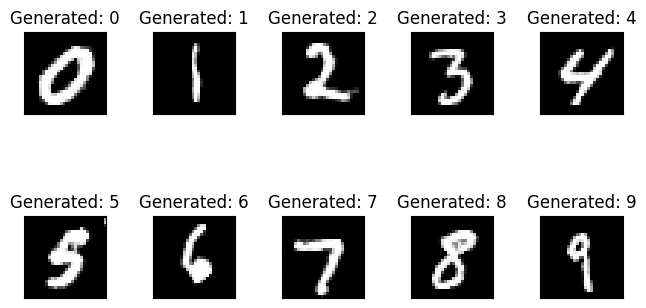

Real Discriminator Accuracy: 0.5394
Fake Discriminator Accuracy: 0.7772
Epoch 165, Noise 1.4092370798741905e-08:


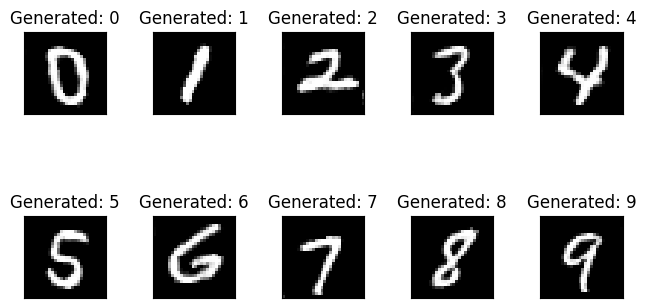

Real Discriminator Accuracy: 0.5582
Fake Discriminator Accuracy: 0.7624
Epoch 166, Noise 1.2683133718867715e-08:


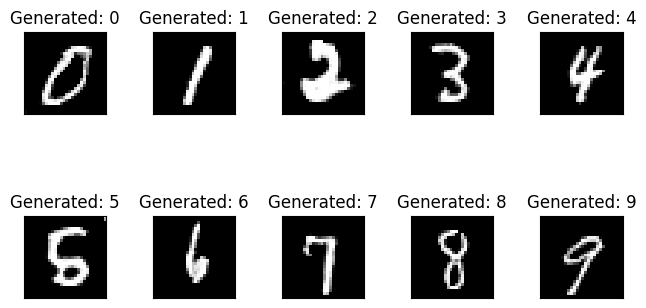

Real Discriminator Accuracy: 0.5681
Fake Discriminator Accuracy: 0.7494
Epoch 167, Noise 1.1414820346980944e-08:


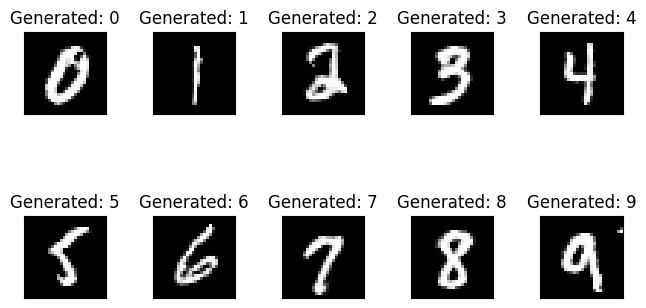

Real Discriminator Accuracy: 0.4408
Fake Discriminator Accuracy: 0.8484
Epoch 168, Noise 1.027333831228285e-08:


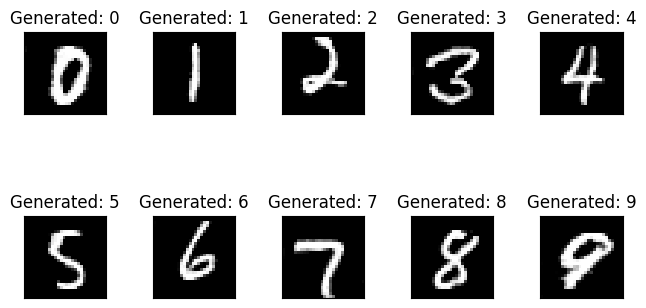

Real Discriminator Accuracy: 0.4182
Fake Discriminator Accuracy: 0.8537
Epoch 169, Noise 9.246004481054565e-09:


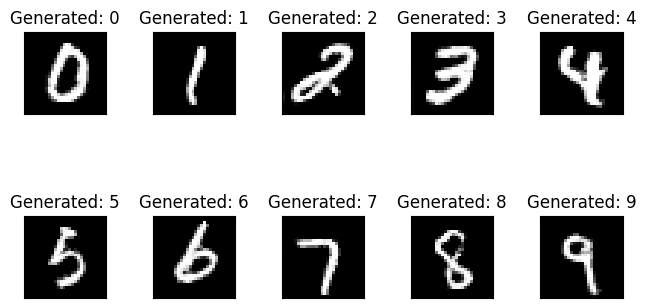

Real Discriminator Accuracy: 0.5452
Fake Discriminator Accuracy: 0.7773
Epoch 170, Noise 8.321404032949109e-09:


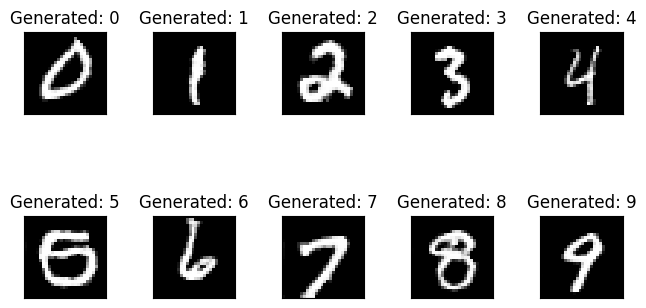

Real Discriminator Accuracy: 0.5556
Fake Discriminator Accuracy: 0.7515
Epoch 171, Noise 7.489263629654198e-09:


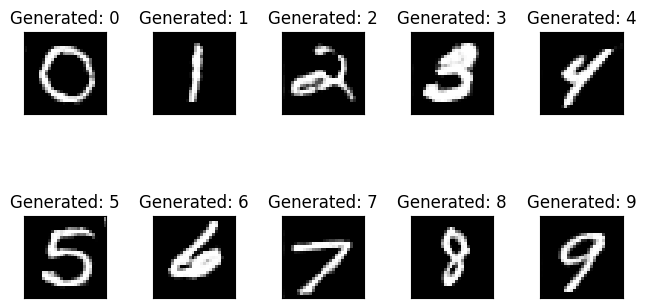

Real Discriminator Accuracy: 0.5422
Fake Discriminator Accuracy: 0.7532
Epoch 172, Noise 6.7403372666887786e-09:


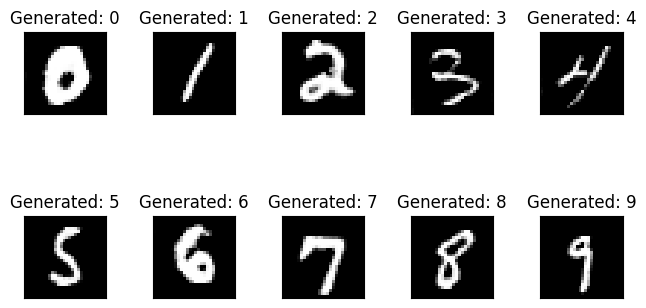

Real Discriminator Accuracy: 0.4477
Fake Discriminator Accuracy: 0.8373
Epoch 173, Noise 6.066303540019901e-09:


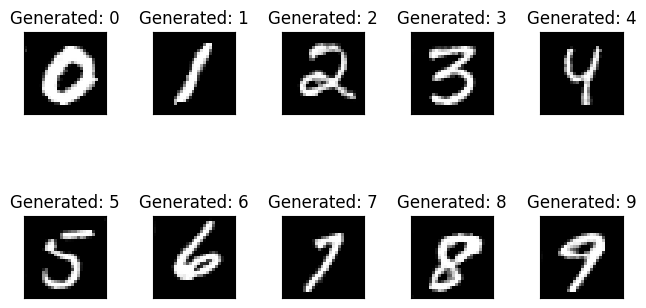

Real Discriminator Accuracy: 0.5064
Fake Discriminator Accuracy: 0.8082
Epoch 174, Noise 5.459673186017911e-09:


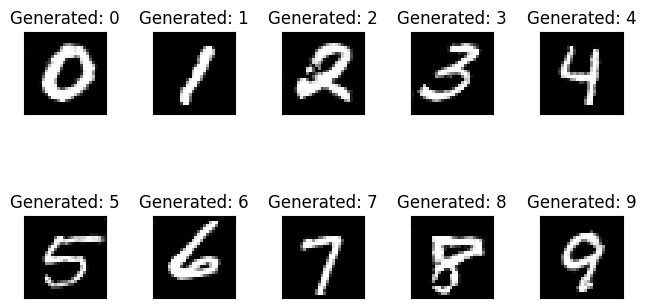

Real Discriminator Accuracy: 0.5659
Fake Discriminator Accuracy: 0.7365
Epoch 175, Noise 4.91370586741612e-09:


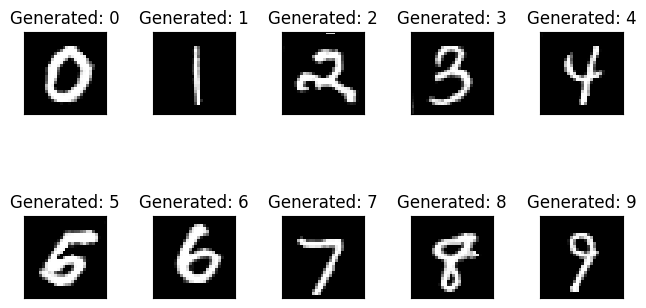

Real Discriminator Accuracy: 0.5709
Fake Discriminator Accuracy: 0.732
Epoch 176, Noise 4.422335280674508e-09:


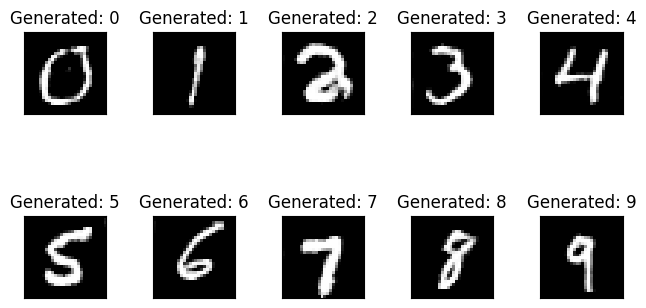

Real Discriminator Accuracy: 0.4765
Fake Discriminator Accuracy: 0.827
Epoch 177, Noise 3.9801017526070575e-09:


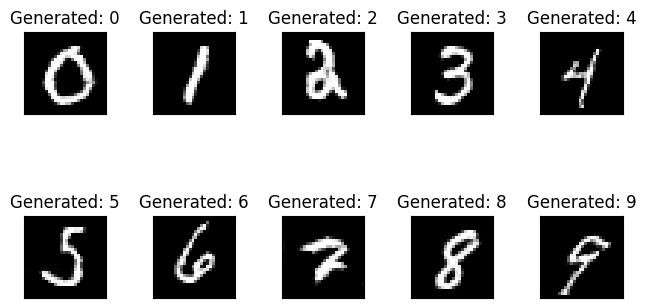

Real Discriminator Accuracy: 0.4473
Fake Discriminator Accuracy: 0.8392
Epoch 178, Noise 3.5820915773463516e-09:


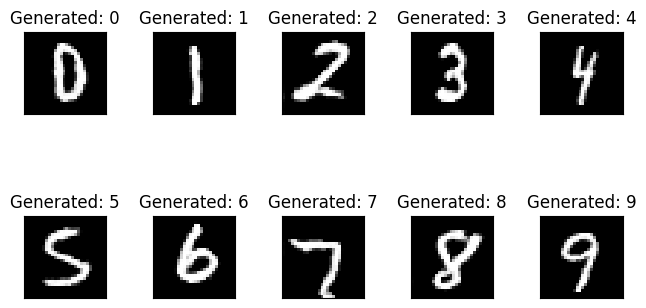

Real Discriminator Accuracy: 0.5233
Fake Discriminator Accuracy: 0.7775
Epoch 179, Noise 3.2238824196117167e-09:


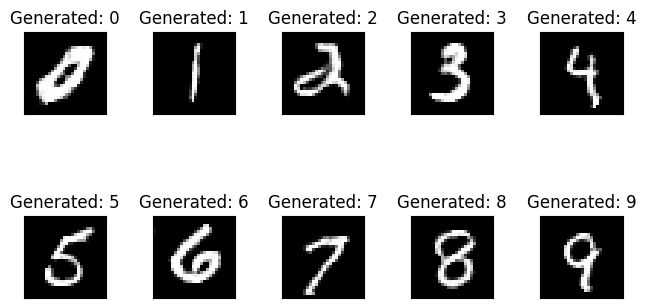

Real Discriminator Accuracy: 0.4953
Fake Discriminator Accuracy: 0.792
Epoch 180, Noise 2.901494177650545e-09:


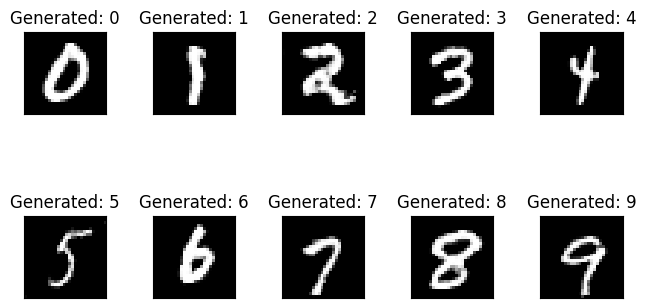

Real Discriminator Accuracy: 0.4872
Fake Discriminator Accuracy: 0.799
Epoch 181, Noise 2.6113447598854904e-09:


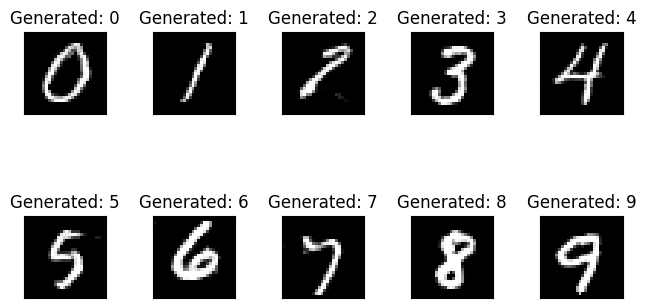

Real Discriminator Accuracy: 0.4675
Fake Discriminator Accuracy: 0.8169
Epoch 182, Noise 2.3502102838969416e-09:


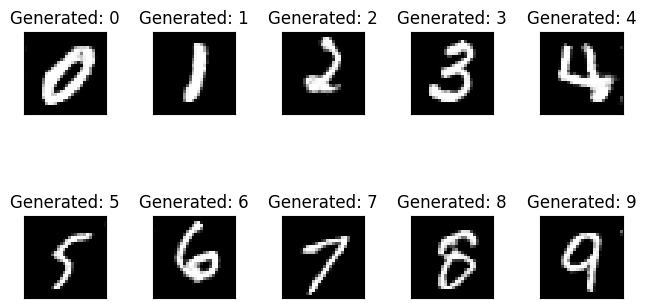

Real Discriminator Accuracy: 0.5042
Fake Discriminator Accuracy: 0.807
Epoch 183, Noise 2.1151892555072475e-09:


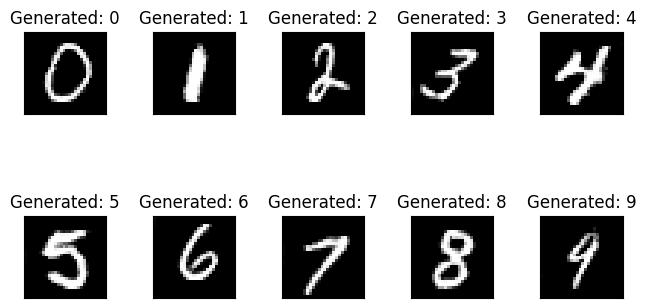

Real Discriminator Accuracy: 0.4584
Fake Discriminator Accuracy: 0.8358
Epoch 184, Noise 1.903670329956523e-09:


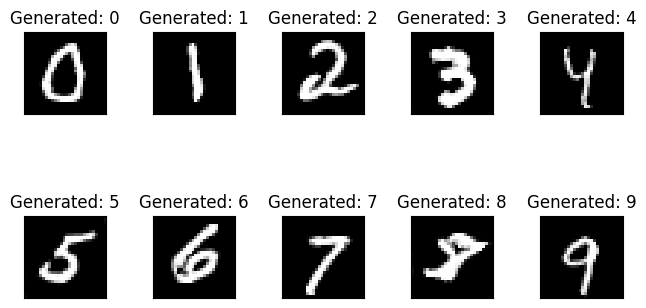

Real Discriminator Accuracy: 0.5965
Fake Discriminator Accuracy: 0.6844
Epoch 185, Noise 1.7133032969608705e-09:


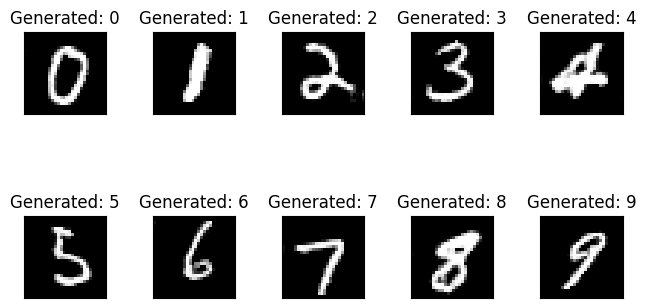

Real Discriminator Accuracy: 0.529
Fake Discriminator Accuracy: 0.773
Epoch 186, Noise 1.5419729672647836e-09:


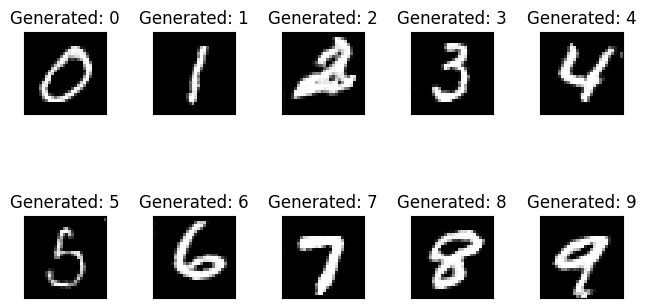

Real Discriminator Accuracy: 0.4455
Fake Discriminator Accuracy: 0.839
Epoch 187, Noise 1.3877756705383052e-09:


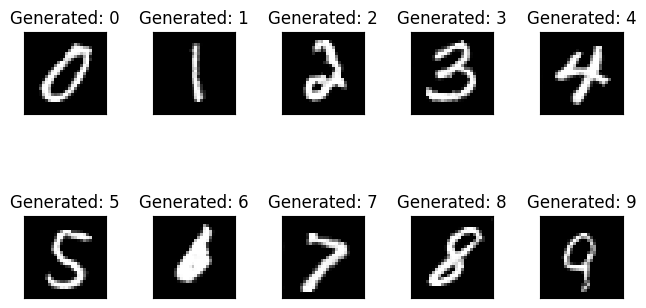

Real Discriminator Accuracy: 0.5053
Fake Discriminator Accuracy: 0.79
Epoch 188, Noise 1.2489981034844747e-09:


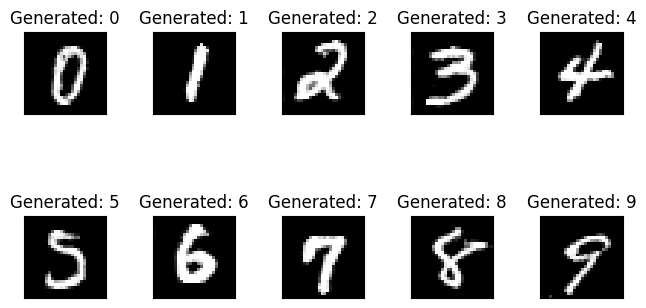

Real Discriminator Accuracy: 0.5435
Fake Discriminator Accuracy: 0.7502
Epoch 189, Noise 1.1240982931360273e-09:


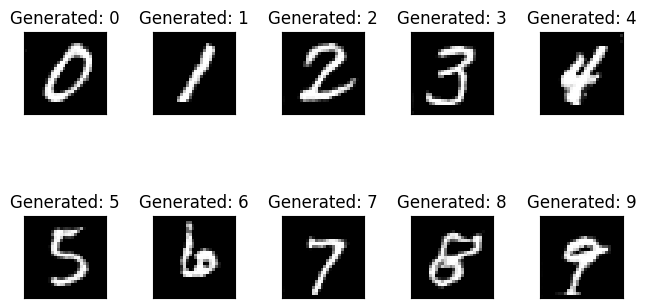

Real Discriminator Accuracy: 0.5358
Fake Discriminator Accuracy: 0.7645
Epoch 190, Noise 1.0116884638224246e-09:


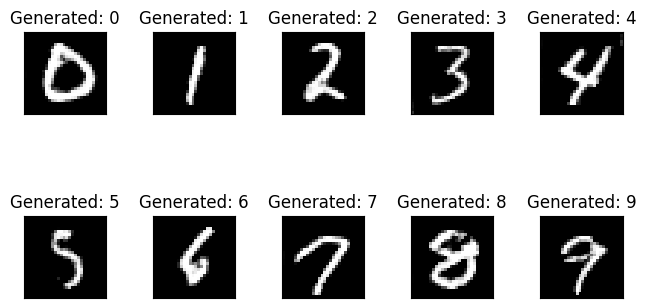

Real Discriminator Accuracy: 0.4725
Fake Discriminator Accuracy: 0.8159
Epoch 191, Noise 9.105196174401821e-10:


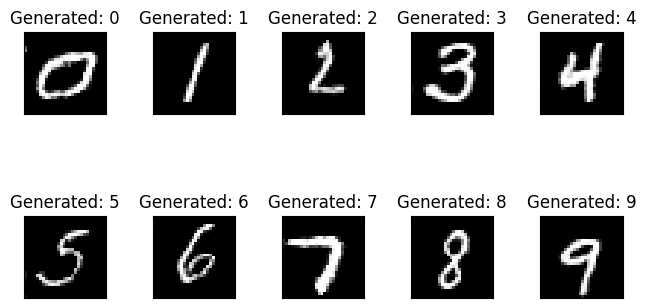

Real Discriminator Accuracy: 0.4986
Fake Discriminator Accuracy: 0.7933
Epoch 192, Noise 8.19467655696164e-10:


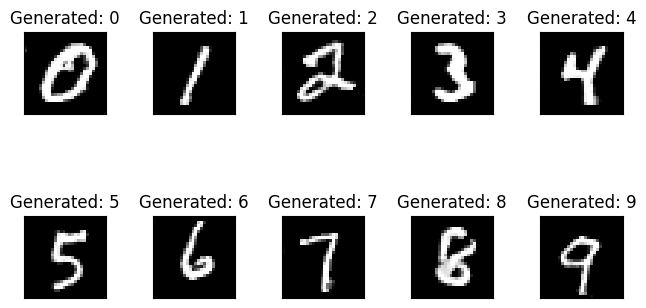

Real Discriminator Accuracy: 0.479
Fake Discriminator Accuracy: 0.8239
Epoch 193, Noise 7.375208901265476e-10:


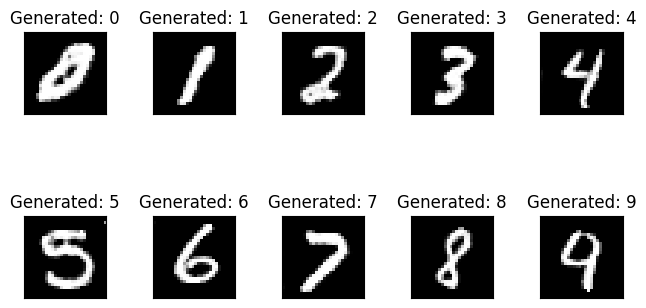

Real Discriminator Accuracy: 0.4582
Fake Discriminator Accuracy: 0.8175
Epoch 194, Noise 6.637688011138928e-10:


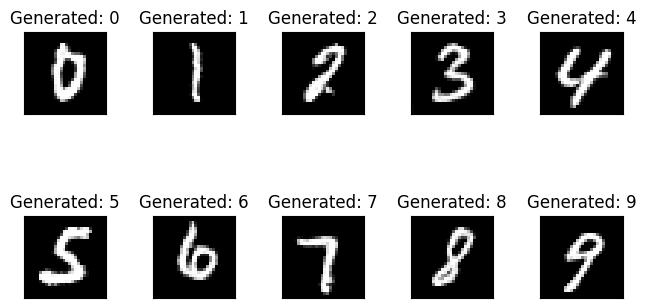

Real Discriminator Accuracy: 0.5089
Fake Discriminator Accuracy: 0.783
Epoch 195, Noise 5.973919210025035e-10:


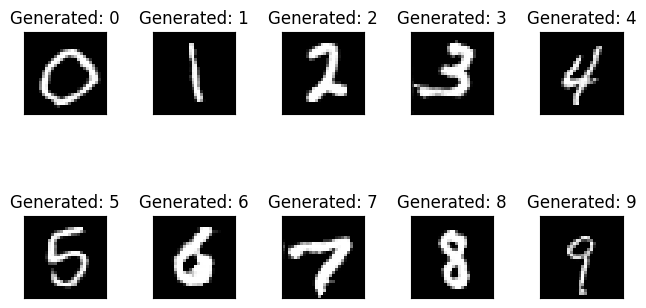

Real Discriminator Accuracy: 0.5066
Fake Discriminator Accuracy: 0.7845
Epoch 196, Noise 5.376527289022532e-10:


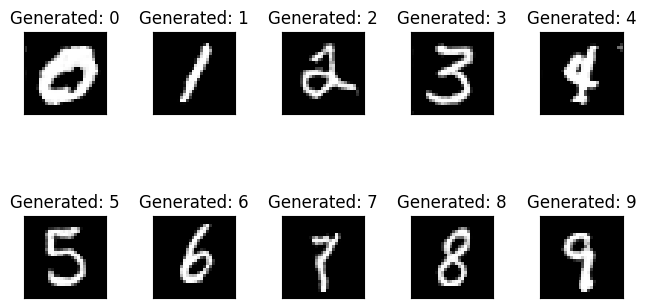

Real Discriminator Accuracy: 0.5016
Fake Discriminator Accuracy: 0.7806
Epoch 197, Noise 4.838874560120279e-10:


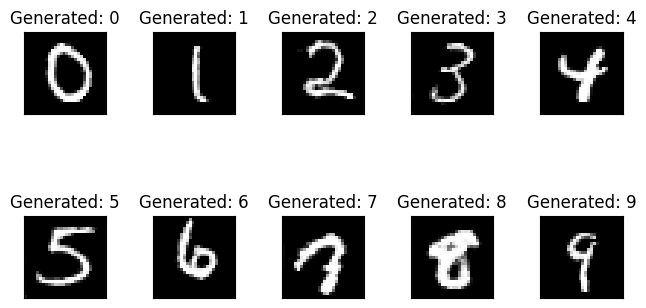

Real Discriminator Accuracy: 0.5269
Fake Discriminator Accuracy: 0.7607
Epoch 198, Noise 4.3549871041082513e-10:


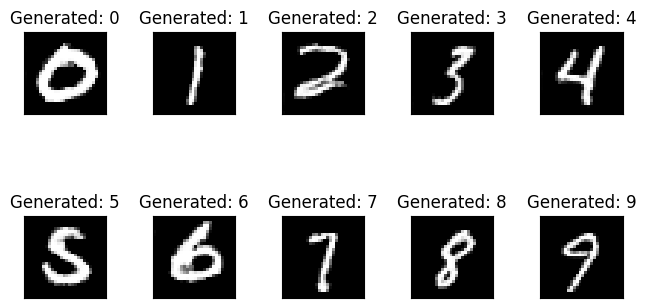

Real Discriminator Accuracy: 0.5329
Fake Discriminator Accuracy: 0.7508
Epoch 199, Noise 3.9194883936974263e-10:


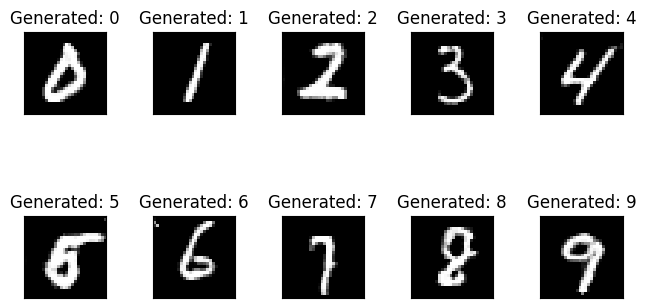

Real Discriminator Accuracy: 0.4922
Fake Discriminator Accuracy: 0.7916


In [29]:
def draw_generator_samples():
    fig = plt.figure()
    for i in range(10):
        labels = F.one_hot(torch.tensor([i]), output_dim).to(device)
        gen_img = generator(torch.stack(tuple([torch.cat((label, torch.randn(latent_dimension).to(device))) for label in labels])))   
        plt.subplot(2, 5, i+1)
        plt.tight_layout()
        plt.imshow(gen_img.detach().cpu().numpy()[0][0], cmap="gray", interpolation="none")
        plt.title(f"Generated: {i}")
        plt.xticks([])
        plt.yticks([])
    plt.show()

for t in range(epochs):
    noise_quantity = noise_0*(noise_decay**t)
    print(f"Epoch {t}, Noise {noise_quantity}:")
    # TRAIN
    discriminator.train()
    generator.train()

    for _, (x, y) in enumerate(train_dataloader):
        x=(x+torch.randn_like(x)*noise_quantity).to(device) # ADD NOISE
        y=y.to(device)

        labels = F.one_hot(y, output_dim).to(device)

        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        # TRAIN DISCRIMINATOR
        gen_data = torch.cat((labels, torch.randn((labels.size(0), latent_dimension)).to(device)), dim=1)
        gen_data = gen_data.to(device)
        fake_imgs = generator(gen_data)
        fake_imgs = fake_imgs + (torch.randn_like(fake_imgs)*noise_quantity).to(device) # add noise
        fake_imgs.detach()
        real_data_results = discriminator((x, labels))
        fake_data_results = discriminator((fake_imgs, labels))

        d_loss = F.mse_loss(real_data_results, torch.ones_like(real_data_results)) + F.mse_loss(fake_data_results, torch.zeros_like(fake_data_results))
        d_loss.backward()
        discriminator_optimizer.step()

        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        # TRAIN GENERATOR
        gen_data = torch.cat((labels, torch.randn((labels.size(0), latent_dimension)).to(device)), dim=1)
        gen_data = gen_data.to(device)
        fake_imgs = generator(gen_data)
        fake_imgs = fake_imgs + (torch.randn_like(fake_imgs)*noise_quantity).to(device) # add noise
        fake_data_results = discriminator((fake_imgs, labels))
        g_loss = F.mse_loss(fake_data_results, torch.ones_like(fake_data_results))
        g_loss.backward()
        generator_optimizer.step()

    # TEST
    discriminator.eval()
    generator.eval()
    with torch.no_grad():
        draw_generator_samples()
        size=len(validation_dataloader.dataset)
        discriminator_real_accuracy = 0
        discriminator_fake_accuracy = 0
        for _, (x, y) in enumerate(validation_dataloader):
            labels = F.one_hot(y, output_dim)
            labels = labels.to(device)
            gen_data = torch.cat((labels, torch.randn((labels.size(0), latent_dimension)).to(device)), dim=1)
            gen_data = gen_data.to(device)
            fake_imgs = generator(gen_data)
            fake_imgs = fake_imgs + (torch.randn_like(fake_imgs)*noise_quantity).to(device) # add noise
            x=(x+torch.randn_like(x)*noise_quantity).to(device) # ADD NOISE
            discriminator_real_accuracy += (discriminator((x, labels))>0.5).sum().item()
            discriminator_fake_accuracy += (discriminator((fake_imgs, labels)) < 0.5).sum().item()

        discriminator_real_accuracy /= size
        discriminator_fake_accuracy /= size
        print(f"Real Discriminator Accuracy: {discriminator_real_accuracy}")
        print(f"Fake Discriminator Accuracy: {discriminator_fake_accuracy}")

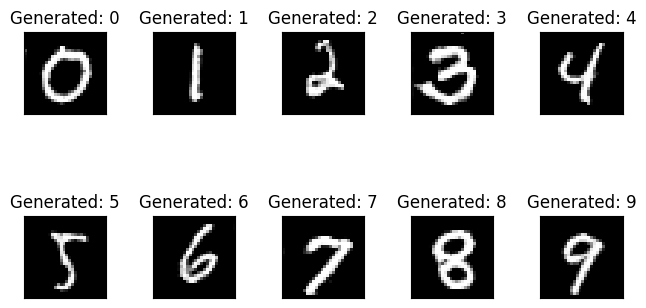

In [30]:
examples = enumerate(validation_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(10):
    labels = F.one_hot(torch.tensor([i]), output_dim).to(device)
    gen_img = generator(torch.stack(tuple([torch.cat((label, torch.randn(latent_dimension).to(device))) for label in labels])))   
    plt.subplot(2, 5, i+1)
    plt.tight_layout()
    plt.imshow(gen_img.detach().cpu().numpy()[0][0], cmap="gray", interpolation="none")
    plt.title(f"Generated: {i}")
    plt.xticks([])
    plt.yticks([])

In [31]:
torch.save(discriminator.state_dict(), "./files/model_data/gandiscriminator.pt")
torch.save(generator.state_dict(), "./files/model_data/gangenerator.pt")